# Figures to assess the chemical differences across GALAH's elements

To assess the chemical differences, we built on the work by Nissen et al. (2011), especially their approach shown in Fig. 5, to look into how distinct the abundance differences between disk and (low-$\alpha$) halo are across periodic table as measured by GALAH.

#### Author(s):
Sven Buder

#### History:
210413: Created

![](literature/2011AandA...530...15_Fig5.png)

In [1]:
# Preamble for notebook 

# Compatibility with Python 3
from __future__ import (absolute_import, division, print_function)

try:
    %matplotlib inline
    %config InlineBackend.figure_format='retina'
except:
    pass

# Basic packages
import warnings
warnings.filterwarnings("ignore")
import numpy as np
np.seterr(divide='ignore', invalid='ignore')
from astropy.table import Table, join
import astropy.units as u
from sklearn import mixture
import scipy.stats
from scipy import linalg
import pickle
import csv
import astropy.units as u
import seaborn as sns
import corner
import itertools
import galpy.util.bovy_coords as bc

# Matplotlib and associated packages for plotting
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import patches
from matplotlib.colors import LogNorm

panels = ['a)','b)','c)','d)','e)','f)','g)','h)','i)','j)']

params = {
    'font.family'        : 'serif',
    'text.usetex'        : True, 
    'text.latex.preamble': [r'\usepackage{upgreek}', r'\usepackage{amsmath}'],
    }   

plt.rcParams.update(params)

In [2]:
def get_and_join_data(directory = '../data/'):
    
    # Join all data
    galah_dr3_main = Table.read(directory+'GALAH_DR3_main_allspec_v2.fits')
    galah_dr3_dynamics = Table.read(directory+'GALAH_DR3_VAC_dynamics_v2.fits')
    galah_dr3_gaiaedr3 = Table.read(directory+'GALAH_DR3_VAC_GaiaEDR3_v2.fits')
    galah_dr3_ages = Table.read(directory+'GALAH_DR3_VAC_ages_v2.fits')
    galah_dr3_rv = Table.read(directory+'GALAH_DR3_VAC_rv_v2.fits')
    data_12 = join(galah_dr3_main, galah_dr3_dynamics, keys='sobject_id')
    data_123 = join(data_12, galah_dr3_gaiaedr3, keys='sobject_id')
    data_1234 = join(data_123, galah_dr3_ages, keys='sobject_id')
    data = join(data_1234, galah_dr3_rv, keys='sobject_id')
    
    # get best rv and e_rv
    data['best_rv'] = np.zeros(len(data['sobject_id'])); data['best_rv'][:] = np.nan;
    data['best_rv'][data['use_rv_flag_1']==0] = data['rv_obst'][data['use_rv_flag_1']==0]
    data['best_rv'][data['use_rv_flag_1']==1] = data['rv_sme_v2'][data['use_rv_flag_1']==1]
    data['best_rv'][data['use_rv_flag_1']==2] = data['dr2_radial_velocity_1'][data['use_rv_flag_1']==2]

    data['best_e_rv'] = np.zeros(len(data['sobject_id'])); data['best_e_rv'][:] = np.nan;
    data['best_e_rv'][data['use_rv_flag_1']==0] = data['e_rv_obst'][data['use_rv_flag_1']==0]
    data['best_e_rv'][data['use_rv_flag_1']==1] = data['e_rv_sme'][data['use_rv_flag_1']==1]
    data['best_e_rv'][data['use_rv_flag_1']==2] = data['dr2_radial_velocity_error_1'][data['use_rv_flag_1']==2]
    
    # get best distance and 16th + 84th percentile
    data['best_d'] = np.zeros(len(data['sobject_id'])); data['best_d'][:] = np.nan;
    data['best_d_16'] = np.zeros(len(data['sobject_id'])); data['best_d_16'][:] = np.nan;
    data['best_d_50'] = np.zeros(len(data['sobject_id'])); data['best_d_50'][:] = np.nan;
    data['best_d_84'] = np.zeros(len(data['sobject_id'])); data['best_d_84'][:] = np.nan;

    data['best_d'][data['use_dist_flag']==0] = 1000.*data['distance_bstep'][data['use_dist_flag']==0]
    data['best_d_16'][data['use_dist_flag']==0] = 1000.*data['e16_distance_bstep'][data['use_dist_flag']==0]
    data['best_d_50'][data['use_dist_flag']==0] = 1000.*data['e50_distance_bstep'][data['use_dist_flag']==0]
    data['best_d_84'][data['use_dist_flag']==0] = 1000.*data['e84_distance_bstep'][data['use_dist_flag']==0]

    data['best_d'][data['use_dist_flag']==1] = data['r_med_photogeo'][data['use_dist_flag']==1]
    data['best_d_16'][data['use_dist_flag']==1] = data['r_lo_photogeo'][data['use_dist_flag']==1]
    data['best_d_50'][data['use_dist_flag']==1] = data['r_med_photogeo'][data['use_dist_flag']==1]
    data['best_d_84'][data['use_dist_flag']==1] = data['r_hi_photogeo'][data['use_dist_flag']==1]

    data['best_d'][data['use_dist_flag']==2] = data['r_med_geo'][data['use_dist_flag']==2]
    data['best_d_16'][data['use_dist_flag']==2] = data['r_lo_geo'][data['use_dist_flag']==2]
    data['best_d_50'][data['use_dist_flag']==2] = data['r_med_geo'][data['use_dist_flag']==2]
    data['best_d_84'][data['use_dist_flag']==2] = data['r_hi_geo'][data['use_dist_flag']==2]

    data['best_d'][data['use_dist_flag']==4] = 1000./data['parallax_corr'][data['use_dist_flag']==4]
    data['best_d_16'][data['use_dist_flag']==4] = 1000./(data['parallax_corr'][data['use_dist_flag']==4]+data['parallax_error'][data['use_dist_flag']==4])
    data['best_d_50'][data['use_dist_flag']==4] = 1000./(data['parallax_corr'][data['use_dist_flag']==4]-data['parallax_error'][data['use_dist_flag']==4])
    data['best_d_84'][data['use_dist_flag']==4] = 1000./data['r_hi_geo'][data['use_dist_flag']==4]

    data['theta_spherical'] = np.arctan2(data['R_Rzphi'], data['z_Rzphi'])
    data['rho_spherical'] = np.sqrt((data['R_Rzphi'])**2+(data['z_Rzphi'])**2)
    data['vrho_spherical'] = (data['R_Rzphi']*data['vR_Rzphi'] + data['z_Rzphi']*data['vz_Rzphi'])/data['rho_spherical']
    data['vtheta_spherical'] = (data['z_Rzphi']*data['vR_Rzphi'] - data['R_Rzphi']*data['vz_Rzphi'])/data['rho_spherical']

    return data

# test if joined data file already exists
try:
    data = Table.read('../data/GALAH_DR3_all_joined_v2.fits')
except:
    data = get_and_join_data(directory = '../../data/')
    data.write('../data/GALAH_DR3_all_joined_v2.fits')

In [3]:
# Selection basics 

basic_cuts = (
    (data['flag_sp'] == 0) &
    (data['survey_name'] != 'other') &
    (data['flag_fe_h'] == 0) &
    (data['best_d'] <= 10000.) &
    np.isfinite(data['L_Z']) &
    np.isfinite(data['ecc']) &
    np.isfinite(data['age_bstep'])
)

basic_cuts_mgalpha = (
    basic_cuts &
    (data['flag_alpha_fe'] == 0) &
    (data['flag_Mg_fe'] == 0)
)

def nissen_slope_mg_fe(fe_h):
    """
    Slope [Fe/H] vs. [Mg/Fe] as estimated from 2010A%26A...511L..10N
    
    -1/12 * [Fe/H] + 1/6
    
    """
    return -0.1/1.2*(fe_h)+(0.3 - 1.6*0.1/1.2)

def nissen_slope_alpha_fe(fe_h):
    """
    Slope [Fe/H] vs. [alpha/Fe] as estimated from 2010A%26A...511L..10N
    
    -0.2/1.2*(fe_h)+(0.325 - 1.6*0.2/1.2)
    
    -1/6 * [Fe/H] + 0.7/12
    
    """
    return -0.2/1.2*(fe_h)+(0.325 - 1.6*0.2/1.2)

def total_velocity(data):
    """
    return the total space velocity:
    
    sqrt(pow(rv_galah,2) + (pow(4.7623*r_est/1000.,2)*(pow(pmra,2) + pow(pmdec,2))))
    
    """
    return(
        np.sqrt(
            (data['U_UVW']-11.1)**2 +
            (data['V_UVW']+15.17)**2 +
            (data['W_UVW']+7.25)**2
        )
    )

def total_velocity_rv_pm(data):
    """
    return the total space velocity:
    
    sqrt(pow(rv_galah,2) + (pow(4.7623*r_est/1000.,2)*(pow(pmra,2) + pow(pmdec,2))))
    
    """
    return np.sqrt(
            (data['best_rv'])**2 + 
            (4.7623*data['best_d']/1000.)**2 * 
            ((data['pmra'])**2 + (data['pmdec'])**2)
        )

def tangential_velocity(data):
    return (4.7623*data['best_d']/1000.)*np.sqrt((data['pmra'])**2 + (data['pmdec'])**2)

rgb = (
    (data['teff'] < 5500) &
    (data['logg'] < 3.25)
)

msto = (
    (data['teff'] >= 5350) &
    (data['logg'] >= 3.5)
)

stars_with_high_vtot = (
    basic_cuts_mgalpha & 
    (total_velocity(data) > 180)
)

stars_with_high_vtot_rv_pm = (
    basic_cuts_mgalpha & 
    (total_velocity_rv_pm(data) > 180)
)

stars_with_high_vtan = (
    basic_cuts_mgalpha & 
    (tangential_velocity(data) > 180)
)

print('CHANGE TO INITIAL VERSION: NOW [FE/H] < -0.4 instead of -0.5!!!!')
preliminary_low_alpha_halo = (
    basic_cuts_mgalpha &
    (total_velocity(data) > 180) &
    (data['fe_h'] >= -2.0) & (data['fe_h'] <= -0.4) &
#    (data['fe_h'] >= -2.0) & (data['fe_h'] <= -0.5) &
    (data['Mg_fe'] < nissen_slope_mg_fe(data['fe_h'])) &
    (data['alpha_fe'] < nissen_slope_alpha_fe(data['fe_h']))#&
#     (~(data['Na_fe'] >= 0.0))&
#     (data['flag_Na_fe'] == 0.)
)

preliminary_high_alpha_halo = (
    basic_cuts_mgalpha &
    (total_velocity(data) > 180) &
    (data['fe_h'] >= -2.0) & (data['fe_h'] <= -0.4) &
#    (data['fe_h'] >= -2.0) & (data['fe_h'] <= -0.5) &
    (data['Mg_fe'] >= nissen_slope_mg_fe(data['fe_h'])) &
    (data['alpha_fe'] >= nissen_slope_alpha_fe(data['fe_h']))
)

# Selection via [Mg/Cu] vs. [Na/Fe]
chem1 = (
    basic_cuts &
    (data['flag_Mg_fe'] == 0) &
    (data['flag_Na_fe'] == 0) &
    (data['flag_Cu_fe'] == 0) &
    (data['Mg_fe'] - data['Cu_fe'] > 0.5) &
    (data['Na_fe'] < -0.1)
)

# Selection via [Mg/Mn] vs. [Na/Fe]
chem2 = (
    basic_cuts &
    (data['flag_Mg_fe'] == 0) &
    (data['flag_Mn_fe'] == 0) &
    (data['flag_Na_fe'] == 0) &
    (np.abs(data['Mg_fe'] - data['Mn_fe'] - 0.5) <= 0.25) &
    (data['Na_fe'] < -0.1)
)

# Selection via [Mg/Mn] vs. [Na/Fe] + [Fe/H]
chem2_mp = (
    basic_cuts &
    (data['flag_Mg_fe'] == 0) &
    (data['flag_Mn_fe'] == 0) &
    (data['flag_Na_fe'] == 0) &
    (np.abs(data['Mg_fe'] - data['Mn_fe'] - 0.5) <= 0.25) &
    (data['Na_fe'] < -0.1) &
    (data['fe_h'] <= -0.5)
)


# Selection via [Mg/Mn] vs. [Al/Fe], like Das+2020 'blob' selection
chem3 = (
    basic_cuts &
    (data['flag_Mg_fe'] == 0) &
    (data['flag_Al_fe'] == 0) &
    (data['flag_Mn_fe'] == 0) &
    (np.abs(data['Al_fe'] - (-0.35)) <= 0.25) &
    (np.abs(data['Mg_fe'] - data['Mn_fe'] - 0.5) <= 0.25)
)

# Selection via [Mg/Mn] vs. [Al/Fe] + [Fe/H] like Das+2020 'metal-poor blob' selection
chem3_mp = (
    basic_cuts &
    (data['flag_Mg_fe'] == 0) &
    (data['flag_Al_fe'] == 0) &
    (data['flag_Mn_fe'] == 0) &
    (np.abs(data['Al_fe'] - (-0.35)) <= 0.25) &
    (np.abs(data['Mg_fe'] - data['Mn_fe'] - 0.5) <= 0.25) &
    (data['fe_h'] < -0.5)
)

# Selection via L_Z and J_R like Feuillet+2020
feuillet2020 = (
    basic_cuts &
    (data['L_Z'] >= -500) &
    (data['L_Z'] <= 500) &
    (data['J_R'] >= 30**2) &
    (data['J_R'] <= 50**2)
)


# Selection via L_Z and E like Helmi+2018
helmi2018 = (
    basic_cuts & 
    (data['L_Z'] > -1500) &
    (data['L_Z'] < 150) &
    (data['Energy'] > -1.8*10**5)
)

# Selection like Naidu+2020, excluding Sagitarius, Alpeh, high-alpha disk and then selection via eccentricity
#naidu2020_sagitarius = (data['L_Y'] < -0.3*data['L_Z'] - 2.5*10**3)
naidu2020_aleph = (
    (data['vT_Rzphi'] < -175) &
    (data['vT_Rzphi'] > 300) & 
    (np.abs(data['vR_Rzphi']) < 75) & 
    (data['fe_h'] > -0.8) & 
    (data['alpha_fe'] < 0.27)
)
naidu2020_highalphadisk = (
    (data['alpha_fe'] > 0.25 - 0.5*(data['fe_h'] + 0.7))
)
naidu2020 = (
    basic_cuts & 
    (data['flag_fe_h'] == 0) &
    (data['flag_alpha_fe'] == 0) &
    # Sagitarius
    (~naidu2020_aleph) &
    (~naidu2020_highalphadisk) &
    (data['ecc'] > 0.7)
)

CHANGE TO INITIAL VERSION: NOW [FE/H] < -0.4 instead of -0.5!!!!


In [4]:
# How many stars are on high tangential and total velocities?

print('Base: ',len(data['sobject_id'][basic_cuts_mgalpha]))
print('Vtot > 180: ',
      len(data['sobject_id'][stars_with_high_vtot]),
      np.round(100*(
               len(data['sobject_id'][stars_with_high_vtot])/
               len(data['sobject_id'][basic_cuts_mgalpha])
           ),1),'%'
     )
print('Vtot (rv+pm) > 180: ',
      len(data['sobject_id'][stars_with_high_vtot_rv_pm]),
      np.round(100*(
               len(data['sobject_id'][stars_with_high_vtot_rv_pm])/
               len(data['sobject_id'][basic_cuts_mgalpha])
           ),1),'%'
     )
print('Vtan > 180: ',
      len(data['sobject_id'][stars_with_high_vtan]),
      np.round(100*(
               len(data['sobject_id'][stars_with_high_vtan])/
               len(data['sobject_id'][basic_cuts_mgalpha])
           ),1),'%'
     )

np.savetxt('../depending_text/percentage_vtan.tex',
           [str(np.round(100*(
               len(data['sobject_id'][stars_with_high_vtan])/
               len(data['sobject_id'][basic_cuts_mgalpha])
           ),1))+'\% ('+str(len(data['sobject_id'][stars_with_high_vtan]))+' spectra)%'],fmt='%s',newline='')
np.savetxt('../depending_text/percentage_vtot.tex',
           [str(np.round(100*(
               len(data['sobject_id'][stars_with_high_vtot])/
               len(data['sobject_id'][basic_cuts_mgalpha])
           ),1))+'\% ('+str(len(data['sobject_id'][stars_with_high_vtot]))+' spectra)%'],fmt='%s',newline='')

Base:  431645
Vtot > 180:  13296 3.1 %
Vtot (rv+pm) > 180:  14096 3.3 %
Vtan > 180:  9894 2.3 %


In [5]:
# Calculate the position of the high-alpha halo, that is stars with high vtot, but not in the low-alpha halo
a16,a50,a84 = np.percentile(data['fe_h'][stars_with_high_vtot & (~preliminary_low_alpha_halo)],q=[16,50,84])
b16,b50,b84 = np.percentile(data['Mg_fe'][stars_with_high_vtot & (~preliminary_low_alpha_halo)],q=[16,50,84])
c16,c50,c84 = np.percentile(data['alpha_fe'][stars_with_high_vtot & (~preliminary_low_alpha_halo)],q=[16,50,84])

location_high_alpha_halo = [
    '$\\mathrm{[Fe/H]} = '+"{:.2f}".format(a50)+'_{-'+"{:.2f}".format(a50-a16)+'}^{+'+"{:.2f}".format(a84-a50)+'}$, '+
    '$\\mathrm{[Mg/Fe]} = '+"{:.2f}".format(b50)+'_{-'+"{:.2f}".format(b50-b16)+'}^{+'+"{:.2f}".format(b84-b50)+'}$, and'+
    '$\\mathrm{[\\alpha/Fe]} = '+"{:.2f}".format(c50)+'_{-'+"{:.2f}".format(c50-c16)+'}^{+'+"{:.2f}".format(c84-c50)+'}$'
    ]

print('Location of the high-alpha halo: ',location_high_alpha_halo[0])
np.savetxt('../depending_text/high_alpha_halo_fehmgfealphafe.tex',location_high_alpha_halo,fmt='%s',newline='')

Location of the high-alpha halo:  $\mathrm{[Fe/H]} = -0.65_{-0.43}^{+0.24}$, $\mathrm{[Mg/Fe]} = 0.29_{-0.11}^{+0.11}$, and$\mathrm{[\alpha/Fe]} = 0.27_{-0.07}^{+0.08}$


In [6]:
# How many stars are we left with for the study of enrichment differences?
nr_preliminary_low_alpha_halo = len(data['fe_h'][preliminary_low_alpha_halo])
print('Low-alpha halo: ',nr_preliminary_low_alpha_halo)
nr_preliminary_low_alpha_halo_na = len(data['fe_h'][preliminary_low_alpha_halo & (data['flag_Na_fe'] == 0)])
print('Low-alpha halo with [Na/Fe]: ',nr_preliminary_low_alpha_halo_na)
np.savetxt('../depending_text/nr_preliminary_low_alpha_halo.tex',[nr_preliminary_low_alpha_halo],fmt='%s',newline='')
np.savetxt('../depending_text/nr_preliminary_low_alpha_halo_na.tex',[nr_preliminary_low_alpha_halo_na],fmt='%s',newline='')

nr_preliminary_high_alpha_halo = len(data['fe_h'][preliminary_high_alpha_halo])
print('High-alpha halo: ',nr_preliminary_high_alpha_halo)
nr_preliminary_high_alpha_halo_na = len(data['fe_h'][preliminary_high_alpha_halo & (data['flag_Na_fe'] == 0)])
print('High-alpha halo with [Na/Fe]: ',nr_preliminary_high_alpha_halo_na)
np.savetxt('../depending_text/nr_preliminary_high_alpha_halo.tex',[nr_preliminary_high_alpha_halo],fmt='%s',newline='')
np.savetxt('../depending_text/nr_preliminary_high_alpha_halo_na.tex',[nr_preliminary_high_alpha_halo_na],fmt='%s',newline='')

Low-alpha halo:  4164
Low-alpha halo with [Na/Fe]:  3838
High-alpha halo:  5325
High-alpha halo with [Na/Fe]:  5230


In [7]:
# Calculate the median uncertainties compared to Nissen+2010

median_uncertainties = "{:.2f}".format(np.round(np.median(data['e_fe_h'][stars_with_high_vtot]),2))+', '+"{:.2f}".format(np.round(np.median(data['e_Mg_fe'][stars_with_high_vtot]),2))+', and '+"{:.2f}".format(np.round(np.median(data['e_alpha_fe'][stars_with_high_vtot]),2))
print('Median uncertainties of kinematic halo for [Fe/H], [Mg/Fe], and [\alpha/Fe]: ',median_uncertainties)
print('Compared to Nissen & Schuster (2010): 0.03, 0.03, 0.02')
np.savetxt('../depending_text/median_uncertainties_fehmgfealphafe.tex',[median_uncertainties],fmt='%s',newline='')

Median uncertainties of kinematic halo for [Fe/H], [Mg/Fe], and [lpha/Fe]:  0.09, 0.10, and 0.04
Compared to Nissen & Schuster (2010): 0.03, 0.03, 0.02


In [8]:
def plot_nissen_selection():
    """
    Here we plot the two selection criteria,
    that Nissen & Schuster, A&A, 511, L10 (2010) used
    to identify the low-alpha halo.
    
    Panel a) Toomre diagram
    Panel b) [Mg/Fe]
    
    INPUT:
    plot_builtup : 1: including GALAH DR3 (all)
    plot_builtup : 2: including stars with halo kinematics
    plot_builtup : -1: everything
    
    """

    f, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(9,3.5),constrained_layout=True)

    # Panel a)
    toomre_kwargs = dict(bins=(np.linspace(-699,299,100),np.linspace(0,499,50)), cmin=1)
    ax1.set_xlim(-699,299)
    ax1.set_ylim(0,499)
    h1 = ax1.hist2d(
        data['V_UVW'][basic_cuts_mgalpha],
        np.sqrt(data['U_UVW'][basic_cuts_mgalpha]**2+data['W_UVW'][basic_cuts_mgalpha]**2),
        label='GALAH~DR3',cmap='Greys',norm=LogNorm(),vmax=10**4,
        **toomre_kwargs
    )
    ax1.errorbar(
        [-600],
        [50],
        xerr=[
            [np.median(data['V_UVW_95'][basic_cuts_mgalpha] - data['V_UVW_50'][basic_cuts_mgalpha])],
            [np.median(data['V_UVW_50'][basic_cuts_mgalpha] - data['V_UVW_5'][basic_cuts_mgalpha])]
        ],
        yerr=[
            [np.sqrt(
                np.median(data['U_UVW_95'][basic_cuts_mgalpha] - data['U_UVW_50'][basic_cuts_mgalpha])**2+
                np.median(data['W_UVW_95'][basic_cuts_mgalpha] - data['W_UVW_50'][basic_cuts_mgalpha])**2
            )],
            [np.sqrt(
                np.median(data['U_UVW_50'][basic_cuts_mgalpha] - data['U_UVW_5'][basic_cuts_mgalpha])**2+
                np.median(data['W_UVW_50'][basic_cuts_mgalpha] - data['W_UVW_5'][basic_cuts_mgalpha])**2
            )]
        ],
        fmt='none',lw=1,c='k',capsize=1
    )

    h2 = ax1.hist2d(
        data['V_UVW'][stars_with_high_vtot],
        np.sqrt(data['U_UVW'][stars_with_high_vtot]**2+data['W_UVW'][stars_with_high_vtot]**2),
        label=r'$v_\mathrm{tot} > 180\,\mathrm{km\,s^{-1}}$',cmap='Blues',norm=LogNorm(),vmax=10**2,
        **toomre_kwargs
    )       
    ax1.errorbar(
        [-650],
        [50],
        xerr=[
            [np.median(data['V_UVW_95'][stars_with_high_vtot] - data['V_UVW_50'][stars_with_high_vtot])],
            [np.median(data['V_UVW_50'][stars_with_high_vtot] - data['V_UVW_5'][stars_with_high_vtot])]
        ],
        yerr=[
            [np.sqrt(
                np.median(data['U_UVW_95'][stars_with_high_vtot] - data['U_UVW_50'][stars_with_high_vtot])**2+
                np.median(data['W_UVW_95'][stars_with_high_vtot] - data['W_UVW_50'][stars_with_high_vtot])**2
            )],
            [np.sqrt(
                np.median(data['U_UVW_50'][stars_with_high_vtot] - data['U_UVW_5'][stars_with_high_vtot])**2+
                np.median(data['W_UVW_50'][stars_with_high_vtot] - data['W_UVW_5'][stars_with_high_vtot])**2
            )]
        ],
        fmt='none',lw=1,c='dodgerblue',capsize=1
    )
    ax1.axvline(-229,c='r',ls='-',lw=2,label='$V_\mathrm{LSR} = -229\,\mathrm{km/s}$')
    ax1.plot(np.linspace(-180,180,100),np.sqrt(180**2-np.linspace(-180,180,100)**2),ls='dashed',lw=2,c='r',label='$v_\mathrm{tot} = 180\,\mathrm{km/s}$')
    c1 = plt.colorbar(h1[3],ax=ax1,location='top')
    c1.set_label(r'GALAH~DR3 (with quality cuts)')
    ax1.set_xlabel(r'$V_\mathrm{LSR}$ / $\mathrm{km\,s^{-1}}$',fontsize=15)
    ax1.set_ylabel(r'$\sqrt{U_\mathrm{LSR}^2+W_\mathrm{LSR}^2}$ / $\mathrm{km\,s^{-1}}$',fontsize=15)
    ax1.legend(fontsize=10)

    # Panel b)
    feh_alpha_fe_kwargs = dict(bins=(np.linspace(-2.5,0.75,75),np.linspace(-0.25,0.75,50)), cmin=1)
    ax2.set_xlim(-2.5,0.75)
    ax2.set_ylim(-0.25,0.75)
    
    h1 = ax2.hist2d(
        data['fe_h'][basic_cuts_mgalpha],
        data['Mg_fe'][basic_cuts_mgalpha],
        label='GALAH~DR3',cmap='Greys',norm=LogNorm(),vmax=10**4,
        **feh_alpha_fe_kwargs
    )
    ax2.errorbar(
        [-2.1],
        [-0.125],
        xerr=[np.median(data['e_fe_h'][basic_cuts_mgalpha])],
        yerr=[np.median(data['e_Mg_fe'][basic_cuts_mgalpha])],
        fmt='none',lw=1,c='k',capsize=1
    )
    h2 = ax2.hist2d(
        data['fe_h'][stars_with_high_vtot],
        data['Mg_fe'][stars_with_high_vtot],
        label=r'$v_\mathrm{tot} > 180\,\mathrm{km\,s^{-1}}$',cmap='Blues',norm=LogNorm(),vmax=10**2,
        **feh_alpha_fe_kwargs
    )
    ax2.errorbar(
        [-2.3],
        [-0.125],
        xerr=[np.median(data['e_fe_h'][stars_with_high_vtot])],
        yerr=[np.median(data['e_Mg_fe'][stars_with_high_vtot])],
        fmt='none',lw=1,c='dodgerblue',capsize=1
    )
    c2 = plt.colorbar(h2[3],ax=ax2,location='top')
    c2.set_label(r'GALAH~DR3 with $v_\mathrm{tot} > 180\,\mathrm{km\,s^{-1}}$')
    ax2.set_xlabel(r'[Fe/H]',fontsize=15)
    ax2.set_ylabel(r'[Mg/Fe]',fontsize=15)
    ax2.plot([-1.6,-1.6,-0.4,-0.4],[-0.25,0.3,0.2,-0.25,],c='r',lw=2,ls='dashed',label='Nissen+2010',zorder=4)
    ax2.plot([-2.0,-2.0,-1.66,-1.6,-0.4,-0.4],[-0.25,nissen_slope_mg_fe(-2.00),nissen_slope_mg_fe(-1.66),nissen_slope_mg_fe(-1.6),nissen_slope_mg_fe(-0.4),-0.25],c='orange',lw=2,ls='dashed',label='Cleaned Selection',zorder=3)
    ax2.legend(fontsize=10)
    
    # Panel c)
    
    feh_alpha_fe_kwargs = dict(bins=(np.linspace(-2.5,0.75,75),np.linspace(-0.25,0.75,50)), cmin=1)
    ax3.set_xlim(-2.5,0.75)
    ax3.set_ylim(-0.25,0.75)
    
    h1 = ax3.hist2d(
        data['fe_h'][basic_cuts_mgalpha],
        data['alpha_fe'][basic_cuts_mgalpha],
        label='GALAH~DR3',cmap='Greys',norm=LogNorm(),vmax=10**4,
        **feh_alpha_fe_kwargs
    )
    ax3.errorbar(
        [-2.1],
        [-0.125],
        xerr=[np.median(data['e_fe_h'][basic_cuts_mgalpha])],
        yerr=[np.median(data['e_alpha_fe'][basic_cuts_mgalpha])],
        fmt='none',lw=1,c='k',capsize=1
    )
    h2 = ax3.hist2d(
        data['fe_h'][stars_with_high_vtot],
        data['alpha_fe'][stars_with_high_vtot],
        label=r'$v_\mathrm{tot} > 180\,\mathrm{km\,s^{-1}}$',cmap='Blues',norm=LogNorm(),vmax=10**2,
        **feh_alpha_fe_kwargs
    )
    ax3.errorbar(
        [-2.3],
        [-0.125],
        xerr=[np.median(data['e_fe_h'][stars_with_high_vtot])],
        yerr=[np.median(data['e_alpha_fe'][stars_with_high_vtot])],
        fmt='none',lw=1,c='dodgerblue',capsize=1
    )
    c3 = plt.colorbar(h2[3],ax=ax3,location='top')
    c3.set_label(r'GALAH~DR3 with $v_\mathrm{tot} > 180\,\mathrm{km\,s^{-1}}$')
    ax3.set_xlabel(r'[Fe/H]',fontsize=15)
    ax3.set_ylabel(r'[$\alpha$/Fe]',fontsize=15)
    ax3.plot([-2.0,-2.0,-1.6,-0.4,-0.4],[-0.25,nissen_slope_alpha_fe(-2.0),nissen_slope_alpha_fe(-1.6),nissen_slope_alpha_fe(-0.4),-0.25],c='orange',lw=2,ls='dashed',label='Cleaned Selection',zorder=3)
    ax3.legend(fontsize=10)

    props = dict(facecolor='w', edgecolor='None', alpha=0.85)
    ax1.text(0.035,0.9,panels[0],fontsize=15, transform=ax1.transAxes,bbox=props)
    ax2.text(0.035,0.9,panels[1],fontsize=15, transform=ax2.transAxes,bbox=props)
    ax3.text(0.035,0.9,panels[2],fontsize=15, transform=ax3.transAxes,bbox=props)
    
    #plt.tight_layout()

    plt.savefig('nissen_selection.png',bbox_inches='tight',dpi=300);

#plot_nissen_selection()

CHANGE TO INITIAL [FE/H] SELECTION: now < -0.4 instead of -0.5
CHANGE TO INITIAL [FE/H] SELECTION: now < -0.4 instead of -0.5


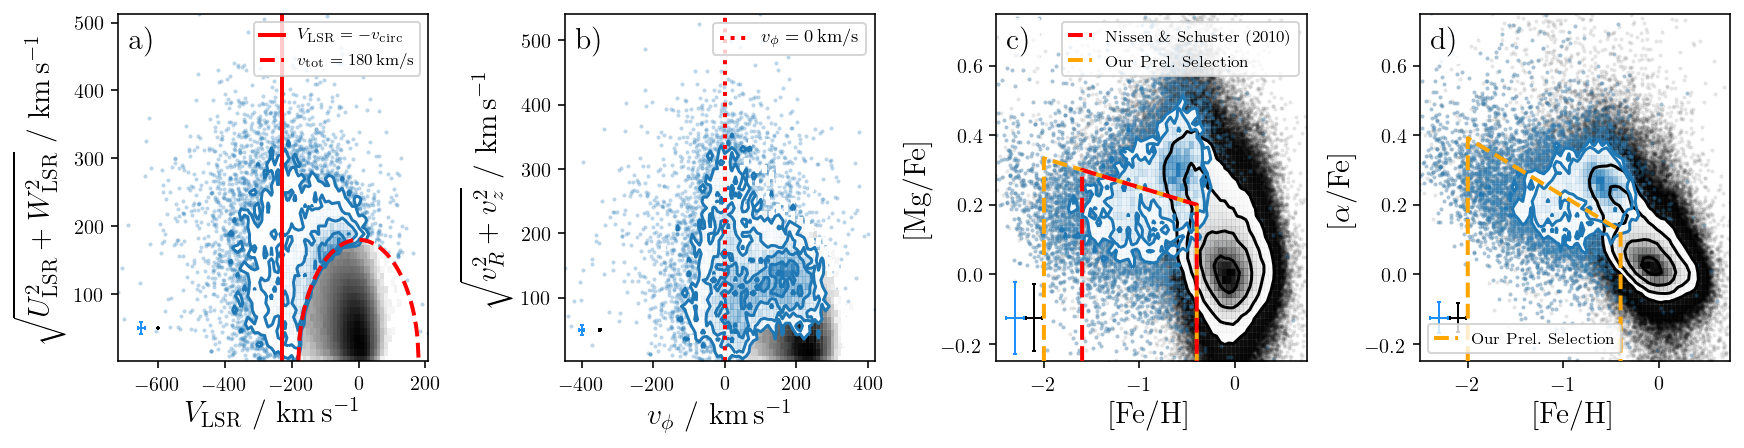

In [9]:
def plot_nissen_selection_corner():
    """
    Here we plot the two selection criteria,
    that Nissen & Schuster, A&A, 511, L10 (2010) used
    to identify the low-alpha halo.
    
    Panel a) Toomre diagram
    Panel b) [Mg/Fe]
    
    INPUT:
    plot_builtup : 1: including GALAH DR3 (all)
    plot_builtup : 2: including stars with halo kinematics
    plot_builtup : -1: everything
    
    """

    f, (ax1, ax11, ax2, ax3) = plt.subplots(1,4,figsize=(12,3.),constrained_layout=True)

    # Panel a)
    toomre_kwargs = dict(bins=(np.linspace(-699,299,100),np.linspace(0,499,50)), cmin=1)
    ax1.set_xlim(-699,299)
    ax1.set_ylim(0,499)

    h1 = ax1.hist2d(
        data['V_UVW'][basic_cuts_mgalpha & (~stars_with_high_vtot)]+15.17,
        np.sqrt(
            (data['U_UVW'][basic_cuts_mgalpha & (~stars_with_high_vtot)]-11.1)**2+
            (data['W_UVW'][basic_cuts_mgalpha & (~stars_with_high_vtot)]+7.25)**2
        ),
        label='GALAH~DR3',cmap='Greys',norm=LogNorm(),vmax=10**4,
        **toomre_kwargs
    )
    ax1.errorbar(
        [-600],
        [50],
        xerr=[
            [np.median(data['V_UVW_95'][basic_cuts_mgalpha] - data['V_UVW_50'][basic_cuts_mgalpha])],
            [np.median(data['V_UVW_50'][basic_cuts_mgalpha] - data['V_UVW_5'][basic_cuts_mgalpha])]
        ],
        yerr=[
            [np.sqrt(
                np.median(data['U_UVW_95'][basic_cuts_mgalpha] - data['U_UVW_50'][basic_cuts_mgalpha])**2+
                np.median(data['W_UVW_95'][basic_cuts_mgalpha] - data['W_UVW_50'][basic_cuts_mgalpha])**2
            )],
            [np.sqrt(
                np.median(data['U_UVW_50'][basic_cuts_mgalpha] - data['U_UVW_5'][basic_cuts_mgalpha])**2+
                np.median(data['W_UVW_50'][basic_cuts_mgalpha] - data['W_UVW_5'][basic_cuts_mgalpha])**2
            )]
        ],
        fmt='none',lw=1,c='k',capsize=1
    )

    corner.hist2d(
        data['V_UVW'][stars_with_high_vtot]+15.17,
        np.sqrt(
            (data['U_UVW'][stars_with_high_vtot]-11.1)**2+
            (data['W_UVW'][stars_with_high_vtot]+7.25)**2
        ),
        label='$v_\mathrm{tot} > 180\,\mathrm{km\,s^{-1}}$',
        bins=(np.linspace(-699,299,100),np.linspace(0,499,50)),
        color='C0',
        #levels=(0.50,0.68,),
        ax=ax1,
        data_kwargs = dict(alpha=0.3),
        rasterized=True,
        #**toomre_kwargs
    )
    ax1.errorbar(
        [-650],
        [50],
        xerr=[
            [np.median(data['V_UVW_95'][stars_with_high_vtot] - data['V_UVW_50'][stars_with_high_vtot])],
            [np.median(data['V_UVW_50'][stars_with_high_vtot] - data['V_UVW_5'][stars_with_high_vtot])]
        ],
        yerr=[
            [np.sqrt(
                np.median(data['U_UVW_95'][stars_with_high_vtot] - data['U_UVW_50'][stars_with_high_vtot])**2+
                np.median(data['W_UVW_95'][stars_with_high_vtot] - data['W_UVW_50'][stars_with_high_vtot])**2
            )],
            [np.sqrt(
                np.median(data['U_UVW_50'][stars_with_high_vtot] - data['U_UVW_5'][stars_with_high_vtot])**2+
                np.median(data['W_UVW_50'][stars_with_high_vtot] - data['W_UVW_5'][stars_with_high_vtot])**2
            )]
        ],
        fmt='none',lw=1,c='dodgerblue',capsize=1
    )
    ax1.axvline(-229,c='r',ls='-',lw=2,label=r'$V_\text{LSR} = - v_\text{circ}$')
    #ax1.axvline(-248.27,c='r',ls='dotted',lw=2,label='$V = - V_\odot = -248.27\,\mathrm{km/s}$')
    ax1.plot(np.linspace(-180,180,100),np.sqrt(180**2-np.linspace(-180,180,100)**2),ls='dashed',lw=2,c='r',label='$v_\mathrm{tot} = 180\,\mathrm{km/s}$')
    #c1 = plt.colorbar(h1[3],ax=ax1,location='top')
    #c1.set_label(r'GALAH~DR3 (with quality cuts)')
    ax1.set_xlabel(r'$V_\text{LSR}$ / $\mathrm{km\,s^{-1}}$',fontsize=15)
    ax1.set_ylabel(r'$\sqrt{U_\text{LSR}^2+W_\text{LSR}^2}$ / $\mathrm{km\,s^{-1}}$',fontsize=15)
    ax1.legend(fontsize=8,loc='upper right',handlelength=1.5,columnspacing=0.5)

    # Panel b)
    toomre_kwargs = dict(bins=(np.linspace(-499,499,100),np.linspace(0,499,50)), cmin=1)
    ax11.set_xlim(-499,499)
    ax11.set_ylim(0,499)

    h1 = ax11.hist2d(
        data['vT_Rzphi'][basic_cuts_mgalpha & (~stars_with_high_vtot)],
        np.sqrt(
            (data['vR_Rzphi'][basic_cuts_mgalpha & (~stars_with_high_vtot)])**2+
            (data['vz_Rzphi'][basic_cuts_mgalpha & (~stars_with_high_vtot)])**2
        ),
        label='GALAH~DR3',cmap='Greys',norm=LogNorm(),vmax=10**4,
        **toomre_kwargs
    )
    ax11.errorbar(
        [-350],
        [50],
        xerr=[
            [np.median(data['vT_Rzphi_95'][basic_cuts_mgalpha] - data['vT_Rzphi_50'][basic_cuts_mgalpha])],
            [np.median(data['vT_Rzphi_50'][basic_cuts_mgalpha] - data['vT_Rzphi_5'][basic_cuts_mgalpha])]
        ],
        yerr=[
            [np.sqrt(
                np.median(data['vR_Rzphi_95'][basic_cuts_mgalpha] - data['vR_Rzphi_50'][basic_cuts_mgalpha])**2+
                np.median(data['vz_Rzphi_95'][basic_cuts_mgalpha] - data['vz_Rzphi_50'][basic_cuts_mgalpha])**2
            )],
            [np.sqrt(
                np.median(data['vR_Rzphi_50'][basic_cuts_mgalpha] - data['vR_Rzphi_5'][basic_cuts_mgalpha])**2+
                np.median(data['vz_Rzphi_50'][basic_cuts_mgalpha] - data['vz_Rzphi_5'][basic_cuts_mgalpha])**2
            )]
        ],
        fmt='none',lw=1,c='k',capsize=1
    )

    corner.hist2d(
        data['vT_Rzphi'][stars_with_high_vtot],
        np.sqrt(
            (-data['vR_Rzphi'][stars_with_high_vtot])**2+
            (data['vz_Rzphi'][stars_with_high_vtot])**2
        ),
        label='$v_\mathrm{LSR,tot} > 180\,\mathrm{km\,s^{-1}}$',
        bins=(np.linspace(-499,499,100),np.linspace(0,499,50)),
        color='C0',
        #levels=(0.50,0.68,),
        ax=ax11,
        data_kwargs = dict(alpha=0.3),
        rasterized=True,
        #**toomre_kwargs
    )
    ax11.errorbar(
        [-400],
        [50],
        xerr=[
            [np.median(data['vT_Rzphi_95'][stars_with_high_vtot] - data['vT_Rzphi_50'][stars_with_high_vtot])],
            [np.median(data['vT_Rzphi_50'][stars_with_high_vtot] - data['vT_Rzphi_5'][stars_with_high_vtot])]
        ],
        yerr=[
            [np.sqrt(
                np.median(data['vR_Rzphi_95'][stars_with_high_vtot] - data['vR_Rzphi_50'][stars_with_high_vtot])**2+
                np.median(data['vz_Rzphi_95'][stars_with_high_vtot] - data['vz_Rzphi_50'][stars_with_high_vtot])**2
            )],
            [np.sqrt(
                np.median(data['vR_Rzphi_50'][stars_with_high_vtot] - data['vR_Rzphi_5'][stars_with_high_vtot])**2+
                np.median(data['vz_Rzphi_50'][stars_with_high_vtot] - data['vz_Rzphi_5'][stars_with_high_vtot])**2
            )]
        ],
        fmt='none',lw=1,c='dodgerblue',capsize=1
    )
    #ax1.axvline(-229,c='r',ls='-',lw=2,label='$V = - v_\text{circ} = -233.1\,\mathrm{km/s}$')
    ax11.axvline(0,c='r',ls='dotted',lw=2,label='$v_\phi = 0\,\mathrm{km/s}$')
    #ax11.plot(np.linspace(-180,180,100),np.sqrt(180**2-np.linspace(-180,180,100)**2),ls='dashed',lw=2,c='r',label='$v_\mathrm{tot} = 180\,\mathrm{km/s}$')
    #c1 = plt.colorbar(h1[3],ax=ax1,location='top')
    #c1.set_label(r'GALAH~DR3 (with quality cuts)')
    ax11.set_xlabel(r'$v_\phi$ / $\mathrm{km\,s^{-1}}$',fontsize=15)
    ax11.set_ylabel(r'$\sqrt{v_R^2+v_z^2}$ / $\mathrm{km\,s^{-1}}$',fontsize=15)
    ax11.legend(fontsize=9,loc='upper right',handlelength=1.5,columnspacing=0.5)
    
    # Panel c)
    bins=(np.linspace(-2.5,0.75,75),np.linspace(-0.25,0.75,50))
    feh_alpha_fe_kwargs = dict(bins=bins, cmin=1)
    
    corner.hist2d(
        data['fe_h'][basic_cuts_mgalpha],
        data['Mg_fe'][basic_cuts_mgalpha],
        color='k',
        ax=ax2,
        rasterized=True,
        bins=(np.linspace(-2.5,0.75,75),np.linspace(-0.25,0.75,50))
    )
#     h1 = ax2.hist2d(
#         data['fe_h'][basic_cuts_mgalpha],
#         data['Mg_fe'][basic_cuts_mgalpha],
#         label='GALAH~DR3',cmap='Greys',norm=LogNorm(),vmax=10**4,
#         **feh_alpha_fe_kwargs
#     )
    ax2.errorbar(
        [-2.1],
        [-0.125],
        xerr=[np.median(data['e_fe_h'][basic_cuts_mgalpha])],
        yerr=[np.median(data['e_Mg_fe'][basic_cuts_mgalpha])],
        fmt='none',lw=1,c='k',capsize=1
    )
    corner.hist2d(
        data['fe_h'][stars_with_high_vtot],
        data['Mg_fe'][stars_with_high_vtot],
        color='C0',
        levels=(0.50,0.68,),
        data_kwargs = dict(alpha=0.3),
        ax=ax2,
        rasterized=True,
        bins=(np.linspace(-2.5,0.75,75),np.linspace(-0.25,0.75,50))
    )
#     h2 = ax2.hist2d(
#         data['fe_h'][stars_with_high_vtot],
#         data['Mg_fe'][stars_with_high_vtot],
#         label=r'$v_\mathrm{tot} > 180\,\mathrm{km\,s^{-1}}$',cmap='Blues',norm=LogNorm(),vmax=10**2,
#         **feh_alpha_fe_kwargs
#     )
    ax2.errorbar(
        [-2.3],
        [-0.125],
        xerr=[np.median(data['e_fe_h'][stars_with_high_vtot])],
        yerr=[np.median(data['e_Mg_fe'][stars_with_high_vtot])],
        fmt='none',lw=1,c='dodgerblue',capsize=1
    )
        
    #c2 = plt.colorbar(h2[3],ax=ax2,location='top')
    #c2.set_label(r'GALAH~DR3 with $v_\mathrm{tot} > 180\,\mathrm{km\,s^{-1}}$')
    ax2.set_xlabel(r'[Fe/H]',fontsize=15)
    ax2.set_ylabel(r'[Mg/Fe]',fontsize=15)
    print('CHANGE TO INITIAL [FE/H] SELECTION: now < -0.4 instead of -0.5')
    ax2.plot([-1.6,-1.6,-0.4,-0.4],[-0.25,0.3,0.2,-0.25,],c='r',lw=2,ls='dashed',label='Nissen \& Schuster (2010)',zorder=4)
#    ax2.plot([-2.0,-2.0,-1.66,-1.6,-0.5,-0.5],[-0.25,nissen_slope_mg_fe(-2.00),nissen_slope_mg_fe(-1.66),nissen_slope_mg_fe(-1.6),nissen_slope_mg_fe(-0.5),-0.25],c='orange',lw=2,ls='dashed',label='Our Prel. Selection',zorder=3)
    ax2.plot([-2.0,-2.0,-1.66,-1.6,-0.4,-0.4],[-0.25,nissen_slope_mg_fe(-2.00),nissen_slope_mg_fe(-1.66),nissen_slope_mg_fe(-1.6),nissen_slope_mg_fe(-0.4),-0.25],c='orange',lw=2,ls='dashed',label='Our Prel. Selection',zorder=3)
    ax2.legend(fontsize=8,loc='upper right',handlelength=1.5,columnspacing=0.5)
    ax2.set_xlim(-2.5,0.75)
    ax2.set_ylim(-0.25,0.75)
    
    # Panel d)
    
    bins=(np.linspace(-2.5,0.75,75),np.linspace(-0.25,0.75,50))
    feh_alpha_fe_kwargs = dict(bins=bins, cmin=1)
    
    corner.hist2d(
        data['fe_h'][basic_cuts_mgalpha],
        data['alpha_fe'][basic_cuts_mgalpha],
        bins=bins,
        color='k',
        ax=ax3
    )
#     h1 = ax3.hist2d(
#         data['fe_h'][basic_cuts_mgalpha],
#         data['alpha_fe'][basic_cuts_mgalpha],
#         label='GALAH~DR3',cmap='Greys',norm=LogNorm(),vmax=10**4,
#         **feh_alpha_fe_kwargs
#     )
    ax3.errorbar(
        [-2.1],
        [-0.125],
        xerr=[np.median(data['e_fe_h'][basic_cuts_mgalpha])],
        yerr=[np.median(data['e_alpha_fe'][basic_cuts_mgalpha])],
        fmt='none',lw=1,c='k',capsize=1
    )
    corner.hist2d(
        data['fe_h'][stars_with_high_vtot],
        data['alpha_fe'][stars_with_high_vtot],
        bins=bins,
        data_kwargs = dict(alpha=0.3),
        levels=(0.50,0.68,),
        color='C0',
        ax=ax3
    )
#     h2 = ax3.hist2d(
#         data['fe_h'][stars_with_high_vtot],
#         data['alpha_fe'][stars_with_high_vtot],
#         label=r'$v_\mathrm{tot} > 180\,\mathrm{km\,s^{-1}}$',cmap='Blues',norm=LogNorm(),vmax=10**2,
#         **feh_alpha_fe_kwargs
#     )
    ax3.errorbar(
        [-2.3],
        [-0.125],
        xerr=[np.median(data['e_fe_h'][stars_with_high_vtot])],
        yerr=[np.median(data['e_alpha_fe'][stars_with_high_vtot])],
        fmt='none',lw=1,c='dodgerblue',capsize=1
    )
    #c3 = plt.colorbar(h2[3],ax=ax3,location='top')
    #c3.set_label(r'GALAH~DR3 with $v_\mathrm{tot} > 180\,\mathrm{km\,s^{-1}}$')
    ax3.set_xlabel(r'[Fe/H]',fontsize=15)
    ax3.set_ylabel(r'[$\alpha$/Fe]',fontsize=15)
    print('CHANGE TO INITIAL [FE/H] SELECTION: now < -0.4 instead of -0.5')
#    ax3.plot([-2.0,-2.0,-1.6,-0.5,-0.5],[-0.25,nissen_slope_alpha_fe(-2.0),nissen_slope_alpha_fe(-1.6),nissen_slope_alpha_fe(-0.5),-0.25],c='orange',lw=2,ls='dashed',label='Our Prel. Selection',zorder=3)
    ax3.plot([-2.0,-2.0,-1.6,-0.4,-0.4],[-0.25,nissen_slope_alpha_fe(-2.0),nissen_slope_alpha_fe(-1.6),nissen_slope_alpha_fe(-0.4),-0.25],c='orange',lw=2,ls='dashed',label='Our Prel. Selection',zorder=3)
    ax3.legend(fontsize=8,handlelength=1.5,columnspacing=0.5)
    ax3.set_xlim(-2.5,0.75)
    ax3.set_ylim(-0.25,0.75)

    props = dict(facecolor='w', edgecolor='None', alpha=0.85)
    ax1.text(0.035,0.9,panels[0],fontsize=15, transform=ax1.transAxes,bbox=props)
    ax11.text(0.035,0.9,panels[1],fontsize=15, transform=ax11.transAxes,bbox=props)
    ax2.text(0.035,0.9,panels[2],fontsize=15, transform=ax2.transAxes,bbox=props)
    ax3.text(0.035,0.9,panels[3],fontsize=15, transform=ax3.transAxes,bbox=props)
    
    #plt.tight_layout()

    plt.savefig('nissen_selection_corner.png',bbox_inches='tight',dpi=200);

plot_nissen_selection_corner()

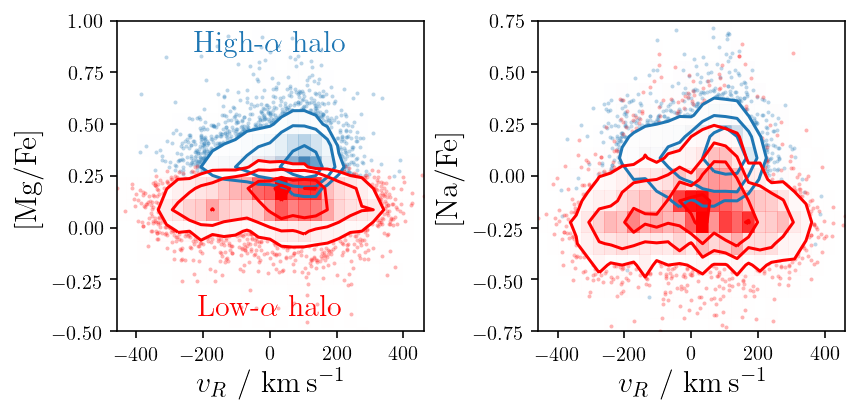

In [55]:
def check_vr_mgfe_vr_nafe():

    f, (ax1,ax2) = plt.subplots(1,2,figsize=(6,3.),constrained_layout=True)

    corner.hist2d(
        data['vR_Rzphi'][preliminary_high_alpha_halo],
        data['Mg_fe'][preliminary_high_alpha_halo],
        label='high-alpha halo',
        bins=(np.linspace(-499,499,30),np.linspace(-1,2,30)),
        color='C0',
        ax=ax1,
        data_kwargs = dict(alpha=0.3),
        rasterized=True,
    )

    corner.hist2d(
        data['vR_Rzphi'][preliminary_low_alpha_halo],
        data['Mg_fe'][preliminary_low_alpha_halo],
        label='low-alpha halo',
        bins=(np.linspace(-499,499,30),np.linspace(-1,2,30)),
        color='r',
        ax=ax1,
        data_kwargs = dict(alpha=0.3),
        rasterized=True,
    )
    ax1.set_ylim(-0.5,1)

    corner.hist2d(
        data['vR_Rzphi'][preliminary_high_alpha_halo & (data['flag_Na_fe']==0)],
        data['Na_fe'][preliminary_high_alpha_halo & (data['flag_Na_fe']==0)],
        label='high-alpha halo',
        bins=(np.linspace(-499,499,30),np.linspace(-1,2,30)),
        color='C0',
        ax=ax2,
        data_kwargs = dict(alpha=0.3),
        rasterized=True,
    )

    corner.hist2d(
        data['vR_Rzphi'][preliminary_low_alpha_halo & (data['flag_Na_fe']==0)],
        data['Na_fe'][preliminary_low_alpha_halo & (data['flag_Na_fe']==0)],
        label='low-alpha halo',
        bins=(np.linspace(-499,499,30),np.linspace(-1,2,30)),
        color='r',
        ax=ax2,
        data_kwargs = dict(alpha=0.3),
        rasterized=True,
    )
    ax1.text(0.5,0.9,r'High-$\alpha$ halo',transform=ax1.transAxes,ha='center',color='C0',fontsize=15)
    ax1.text(0.5,0.05,r'Low-$\alpha$ halo',transform=ax1.transAxes,ha='center',color='r',fontsize=15)
    ax2.set_ylim(-0.75,0.75)
    ax1.set_xlabel(r'$v_R$ / $\mathrm{km\,s^{-1}}$',fontsize=15)
    ax1.set_ylabel(r'[Mg/Fe]',fontsize=15)
    ax2.set_xlabel(r'$v_R$ / $\mathrm{km\,s^{-1}}$',fontsize=15)
    ax2.set_ylabel(r'[Na/Fe]',fontsize=15)
    plt.tight_layout()
    plt.savefig('vR_Mg_Na.png',bbox_inches='tight',dpi=200)
check_vr_mgfe_vr_nafe()

In [57]:
def hist2d_bin_colored(X,Y,Z,X_label='X\_label',Y_label='Y\_label',Z_label='Z\_label',bins=30,bin_function='median',ax=None,minimum_bin_entries = 5,**kwargs):
    """
    INPUT:
    X : x-axis parameter
    Y : y-axis parameter
    Z : parameter that will be used for coloring the bins
    bin_function : median/average/sum
    
    OUTPUT:
    plt.imshow
    """
    
    # First make sure we only work with finite values
    finite = np.isfinite(X) & np.isfinite(Y) & np.isfinite(Z)
    if len(X[finite])!=len(X):
        print('Not all values were finite! Continuing with only finite ones')
    X=X[finite];Y=Y[finite];Z=Z[finite]
    
    # Now create the matrix of bins and its bin-edges
    H,xedges,yedges = np.histogram2d(X,Y,bins=bins)

    # Create the matrix that we want to store color-values in
    color_matrix = np.zeros_like(H)
    color_matrix[:] = np.nan
    
    # Loop through the x- and y-bins
    for x_bin in range(len(xedges)-1):
        for y_bin in range(len(yedges)-1):
            in_xy_bin = (X>=xedges[x_bin])&(X<xedges[x_bin+1])&(Y>=yedges[y_bin])&(Y<yedges[y_bin+1])
            
            # We only add a value if there are more than *minimum_bin_entries* in the bin
            if len(Z[in_xy_bin]) >= minimum_bin_entries:
                if bin_function=='median':
                    color_matrix[x_bin,y_bin]=np.median(Z[in_xy_bin])
                elif bin_function=='average':
                    color_matrix[x_bin,y_bin]=np.average(Z[in_xy_bin])
                elif bin_function=='sum':
                    color_matrix[x_bin,y_bin]=np.sum(Z[in_xy_bin])
                else:
                    raise NameError('Only bin_function = median/average/sum available')

    # Create an axis if not given
    if ax==None:
        ax = plt.gca()
    else:
        ax=ax
    ax.set_xlabel(X_label)
    ax.set_ylabel(Y_label)

    # Populate the keyword arguments for the imshow
    imshow_kwargs = dict(
        cmap = 'seismic_r',aspect='auto',origin='lower'
    )
    # Update by any arguments given through **kwargs
    imshow_kwargs.update(kwargs)

    # Plot!
    s = ax.imshow(color_matrix.T,extent=(xedges[0],xedges[-1],yedges[0],yedges[-1]),**imshow_kwargs)
    c = plt.colorbar(s, ax=ax)
    c.set_label(Z_label)

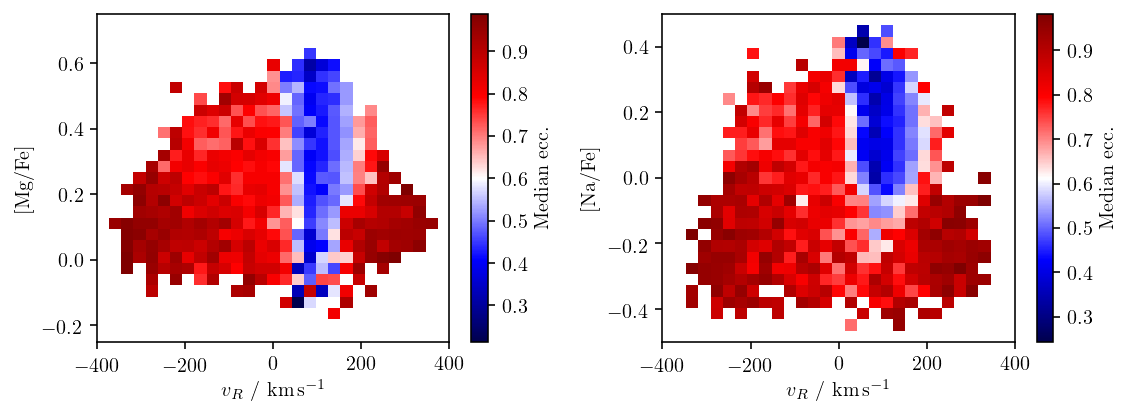

In [77]:
def check_vr_mgfe_vr_nafe_ecc():
    f, gs = plt.subplots(1,2,figsize=(8,3))
    hist2d_bin_colored(
        X=data['vR_Rzphi'][stars_with_high_vtot & (data['flag_Na_fe']==0)],
        Y=data['Mg_fe'][stars_with_high_vtot & (data['flag_Na_fe']==0)],
        Z=data['ecc'][stars_with_high_vtot & (data['flag_Na_fe']==0)],
        X_label=r'$v_R$ / $\mathrm{km\,s^{-1}}$',
        Y_label=r'[Mg/Fe]',
        Z_label=r'Median ecc.',
        cmap='seismic',
        bins=(np.linspace(-400,400,30),np.linspace(-0.25,0.75,30)),
        ax=gs[0]
    )
    hist2d_bin_colored(
        X=data['vR_Rzphi'][stars_with_high_vtot & (data['flag_Na_fe']==0)],
        Y=data['Na_fe'][stars_with_high_vtot & (data['flag_Na_fe']==0)],
        Z=data['ecc'][stars_with_high_vtot & (data['flag_Na_fe']==0)],
        X_label=r'$v_R$ / $\mathrm{km\,s^{-1}}$',
        Y_label=r'[Na/Fe]',
        Z_label=r'Median ecc.',
        cmap='seismic',
        bins=(np.linspace(-400,400,30),np.linspace(-0.5,0.5,30)),
        ax=gs[1]
    )
    plt.tight_layout()
    plt.savefig('vR_Mg_Na_ecc.png',bbox_inches='tight',dpi=300)
check_vr_mgfe_vr_nafe_ecc()

In [10]:
# Get the Nissen 2010, 2011, 2012, 2014 data and Fishlock 2017 data 

#N10 = Table.read('../data/Nissen2010_AA_511_10.fits',1) # no [X/Fe] data in this extension
N10 = Table.read('../data/Nissen2010_AA_511_10.fits',2)
N10['ID'] = [N10['Name'][index].replace(' ','') for index in range(len(N10['Name']))]

N11 = Table.read('../data/Nissen2011_AA_530_15.fits',1)
N12 = Table.read('../data/Nissen2012_AA_543_28.fits',1)
N12['ID'] = [N12['ID'][index].replace(' ','') for index in range(len(N12['ID']))]
#N14_1 = Table.read('../../data/Nissen2014_AA_568_25.fits',1) # no overlap with N10
N14 = Table.read('../data/Nissen2014_AA_568_25.fits',2)
N14['ID'] = [N14['Name'][index].replace(' ','') for index in range(len(N14['Name']))]

# Match the N12 and N14 with N10; N11 already exact match with N10
N10_N12 = []
N12_N10 = []
N10_N14 = []
N14_N10 = []
for each_ind, each in enumerate(N10['ID']):
    found = np.where(N12['ID'] == each)[0]
    if len(found)>0:
        N10_N12.append(each_ind)
        N12_N10.append(found[0])
    found = np.where(N14['ID'] == each)[0]
    if len(found)>0:
        N10_N14.append(each_ind)
        N14_N10.append(found[0])
N12 = N12[N12_N10]
N14 = N14[N14_N10]

# # Sort out
# g15040 = (N10['ID'] == 'G150-40')
# N11['Class'][g15040] = 'Sort'
# g5341 = (N10['ID'] == 'G53-41')
# N10['Class'][g5341] = 'Sort'

F17=Table()
F17['ID']=[
    'CD-453283',
    'CD-61282',
    'G16-20',
    'G18-28',
    'G18-39',
    'G31-55',
    'G56-30',
    'G56-36',
    'G66-22',
    'G170-56',
    'HD3567',
    'HD22879',
    'HD25704',
    'HD76932',
    'HD103723',
    'HD105004',
    'HD111980',
    'HD120559',
    'HD126681',
    'HD179626',
    'HD189558',
    'HD193901',
    'HD194598',
    'HD199289',
    'HD205650',
    'HD219617',
    'HD230409'
]
match = []
for each_id in F17['ID']:
    match.append(np.where(N10['ID'] == each_id)[0][0])
F17['Class'] = N10['Class'][match]
F17['__Fe_H_'] = N10['__Fe_H_'][match]
F17['__Na_Fe_'] = N10['__Na_Fe_'][match]

F17['check'] = [
    -0.91,
    -1.23,
    -1.42,
    -0.83,
    -1.39,
    -1.10,
    -0.89,
    -0.94,
    -0.86,
    -0.92,
    -1.16,
    -0.85,
    -0.85,
    -0.87,
    -0.80,
    -0.82,
    -1.08,
    -0.89,
    -1.17,
    -1.00,
    -1.12,
    -1.07,
    -1.09,
    -1.04,
    -1.17,
    -1.45,
    -0.85,
]
F17['__Sc_Fe_'] = [
    -0.11,
    -0.15,
    -0.11,
    0.11,
    -0.00,
    -0.03,
    -0.22,
    -0.02,
    -0.16,
    -0.14,
    -0.04,
    0.12,
    0.09,
    0.15,
    -0.03,
    -0.04,
    0.00,
    0.17,
    0.00,
    0.12,
    0.09,
    -0.19,
    -0.07,
    0.08,
    -0.01,
    -0.11,
    0.05,
]
F17['__Zr_Fe_'] = [
    -0.07,
    0.00,
    -0.00,
    0.03,
    0.21,
    0.06,
    -0.12,
    0.04,
    -0.08,
    -0.10,
    0.05,
    0.06,
    -0.16,
    0.13,
    -0.05,
    -0.13,
    0.25,
    -0.05,
    0.28,
    0.03,
    0.24,
    -0.14,
    -0.11,
    -0.09,
    0.01,
    -0.05,
    -0.03,
]
F17['__La_Fe_'] = [
    0.00,
    -0.01,
    0.02,
    -0.02,
    0.07,
    -0.08,
    -0.06,
    -0.04,
    -0.04,
    -0.02,
    0.16,
    -0.09,
    -0.02,
    0.03,
    -0.03,
    -0.12,
    0.13,
    -0.05,
    0.14,
    0.02,
    0.07,
    -0.00,
    -0.03,
    -0.12,
    -0.03,
    -0.11,
    -0.00,
]
F17['__Ce_Fe_'] = [
    -0.01,
    -0.05,
    -0.04,
    0.04,
    -0.03,
    -0.11,
    -0.04,
    -0.05,
    0.02,
    -0.16,
    0.07,
    -0.04,
    -0.09,
    -0.08,
    0.01,
    0.10,
    0.09,
    -0.22,
    0.13,
    -0.14,
    0.08,
    -0.08,
    -0.11,
    -0.30,
    -0.07,
    0.18,
    -0.07,
]
F17['__Nd_Fe_'] = [
    0.36,
    0.32,
    0.17,
    0.34,
    0.47,
    0.26,
    -0.09,
    0.31,
    0.34,
    0.14,
    0.33,
    0.34,
    0.33,
    0.36,
    0.33,
    0.10,
    0.33,
    0.32,
    0.34,
    0.14,
    0.24,
    0.31,
    0.17,
    0.15,
    0.14,
    0.03,
    0.43,
]
F17['__Eu_Fe_'] = [
    0.31,
    0.26,
    0.32,
    0.13,
    0.26,
    0.05,
    0.09,
    0.13,
    0.30,
    0.16,
    0.39,
    0.16,
    0.15,
    0.21,
    0.17,
    0.04,
    0.14,
    0.20,
    0.20,
    0.03,
    0.17,
    0.24,
    0.27,
    0.09,
    0.19,
    0.21,
    0.27,
]

In [11]:
def add_nissen_feh_xfe(ax, each):
    if each in ['Li']:
        hah_det = (N12['Pop'] == 'A') & np.isfinite(N12['A_Li'])
        lah_det = (N12['Pop'] == 'B') & np.isfinite(N12['A_Li'])
        td_det = (N12['Pop'] == 'C') & np.isfinite(N12['A_Li'])
        hah_ul = (N12['Pop'] == 'A') & np.isfinite(N12['A_Li_UL'])
        lah_ul = (N12['Pop'] == 'B') & np.isfinite(N12['A_Li_UL'])
        td_ul = (N12['Pop'] == 'C') & np.isfinite(N12['A_Li_UL'])

        ax.scatter(
            N12['fe_h'][hah_det],
            N12['A_Li'][hah_det],
            facecolors='none', edgecolor = 'blue'
        )
        ax.scatter(
            N12['fe_h'][hah_ul],
            N12['A_Li_UL'][hah_ul],
            facecolors='none', edgecolor = 'blue'
        )
        ax.scatter(
            N12['fe_h'][td_det],
            N12['A_Li'][td_det],
            c = 'k',marker='+'
        )
        ax.scatter(
            N12['fe_h'][lah_det],
            N12['A_Li'][lah_det],
            marker='o', c='r'
        )
        ax.errorbar(
            N12['fe_h'][hah_ul],
            N12['A_Li_UL'][hah_ul],
            yerr = 0.1*np.ones_like(N12['fe_h'][hah_ul]),
            c = 'blue',marker='.',fmt='o', markersize=1, uplims = np.ones(len(N12['fe_h'][hah_ul]), dtype=bool)
        )
        ax.errorbar(
            N12['fe_h'][td_ul],
            N12['A_Li_UL'][td_ul],
            yerr = 0.1*np.ones_like(N12['fe_h'][td_ul]),
            c = 'k', marker = '+', fmt='o', uplims = np.ones(len(N12['fe_h'][td_ul]), dtype=bool)
        )
        ax.errorbar(
            N12['fe_h'][lah_ul],
            N12['A_Li_UL'][lah_ul],
            yerr = 0.1*np.ones_like(N12['fe_h'][lah_ul]),
            ecolor = 'r', fmt='o', c='r', uplims = np.ones(len(N12['fe_h'][lah_ul]), dtype=bool)
        )

    if each in ['C','O']:
        hah = (N14['Pop'] == 'A')
        lah = (N14['Pop'] == 'B')
        td =  (N14['Pop'] == 'C')
        
        if each == 'C':
            each_k = '__C_H_n'
        if each == 'O':
            each_k = '__O_H_3n'
        
        ax.scatter(
            N14['__Fe_H_'][hah],
            N14[each_k][hah]-N14['__Fe_H_'][hah],
            facecolors='none', edgecolor = 'blue'
        )
        ax.scatter(
            N14['__Fe_H_'][td],
            N14[each_k][td]-N14['__Fe_H_'][td],
            c = 'k',marker='+'
        )
        ax.scatter(
            N14['__Fe_H_'][lah],
            N14[each_k][lah]-N14['__Fe_H_'][lah],
            marker='o', c='r'
        )
        
    if each in ['Na','Mg','Si','Ca','Ti','Cr','Ni']:
        hah = (N10['Class'] == 'high-alpha')
        lah = (N10['Class'] == 'low-alpha')
        td =  (N10['Class'] == 'TD')
        
        ax.scatter(
            N10['__Fe_H_'][hah],
            N10['__'+each+'_Fe_'][hah],
            facecolors='none', edgecolor = 'blue'
        )
        ax.scatter(
            N10['__Fe_H_'][td],
            N10['__'+each+'_Fe_'][td],
            c = 'k',marker='+'
        )
        ax.scatter(
            N10['__Fe_H_'][lah],
            N10['__'+each+'_Fe_'][lah],
            marker='o', c='r'
        )        

    if each in ['alpha','Mn','Cu','Zn','Y','Ba']:
        hah = (N11['Class'] == 'high-{alpha}  ')
        lah = (N11['Class'] == 'low-{alpha}   ')
        td =  (N11['Class'] == 'TD            ')
        
        each_k = each
        if each == 'alpha':
            each_k = 'a'
        
        ax.scatter(
            N11['__Fe_H_'][hah],
            N11['__'+each_k+'_Fe_'][hah],
            facecolors='none', edgecolor = 'blue'
        )
        ax.scatter(
            N11['__Fe_H_'][td],
            N11['__'+each_k+'_Fe_'][td],
            c = 'k',marker='+'
        )
        ax.scatter(
            N11['__Fe_H_'][lah],
            N11['__'+each_k+'_Fe_'][lah],
            marker='o', c='r'
        )

In [12]:
def add_nissen_nafe_xfe(ax, each):
    
    extra_kwargs = dict(s=7,lw=0.5)
    
    if each in ['Li']:
        hah_det = (N12['Pop'] == 'A') & np.isfinite(N12['A_Li'])
        lah_det = (N12['Pop'] == 'B') & np.isfinite(N12['A_Li'])
        td_det = (N12['Pop'] == 'C') & np.isfinite(N12['A_Li'])
        hah_ul = (N12['Pop'] == 'A') & np.isfinite(N12['A_Li_UL'])
        lah_ul = (N12['Pop'] == 'B') & np.isfinite(N12['A_Li_UL'])
        td_ul = (N12['Pop'] == 'C') & np.isfinite(N12['A_Li_UL'])

        ax.errorbar(
            N10['__Na_Fe_'][N10_N12][hah_ul],
            N12['A_Li_UL'][hah_ul],zorder=4,
            yerr = 0.1*np.ones_like(N12['fe_h'][hah_ul]),
            c = 'b',marker='.',fmt='o', markersize=0.0,elinewidth=0.5,capsize=1, uplims = np.ones(len(N12['fe_h'][hah_ul]), dtype=bool)
        )
        ax.errorbar(
            N10['__Na_Fe_'][N10_N12][td_ul],
            N12['A_Li_UL'][td_ul],zorder=5,
            yerr = 0.1*np.ones_like(N12['fe_h'][td_ul]),
            c = 'k', marker = '+', fmt='o', markersize=0.0,elinewidth=0.5, capsize=1, uplims = np.ones(len(N12['fe_h'][td_ul]), dtype=bool)
        )
        ax.errorbar(
            N10['__Na_Fe_'][N10_N12][lah_ul],
            N12['A_Li_UL'][lah_ul],zorder=6,
            yerr = 0.1*np.ones_like(N12['fe_h'][lah_ul]),
            ecolor = 'r', fmt='o', c='r', markersize=0.0,elinewidth=0.5, capsize=1, uplims = np.ones(len(N12['fe_h'][lah_ul]), dtype=bool)
        )
        ax.scatter(
            N10['__Na_Fe_'][N10_N12][lah_det],
            N12['A_Li'][lah_det],zorder=7,
            marker='o', c='r',**extra_kwargs
        )

        ax.scatter(
            N10['__Na_Fe_'][N10_N12][hah_det],
            N12['A_Li'][hah_det],zorder=8,
            facecolors='none', edgecolor = 'b',**extra_kwargs
        )
        ax.scatter(
            N10['__Na_Fe_'][N10_N12][td_det],
            N12['A_Li'][td_det],zorder=9,
            c = 'k',marker='+',**extra_kwargs
        )

    if each in ['C','O']:
        hah = (N14['Pop'] == 'A')
        lah = (N14['Pop'] == 'B')
        td =  (N14['Pop'] == 'C')
        
        if each == 'C':
            each_k = '__C_H_n'
        if each == 'O':
            each_k = '__O_H_3n'
        
        ax.scatter(
            N10['__Na_Fe_'][N10_N14][hah],
            N14[each_k][hah]-N14['__Fe_H_'][hah],zorder=4,
            facecolors='none', edgecolor = 'blue',**extra_kwargs
        )
        ax.scatter(
            N10['__Na_Fe_'][N10_N14][td],
            N14[each_k][td]-N14['__Fe_H_'][td],zorder=5,
            c = 'k',marker='+',**extra_kwargs
        )
        ax.scatter(
            N10['__Na_Fe_'][N10_N14][lah],
            N14[each_k][lah]-N14['__Fe_H_'][lah],zorder=6,
            marker='o', c='r',**extra_kwargs
        )
        
    if each in ['Sc','Zr','La','Ce','Nd','Eu']:
        hah = (F17['Class'] == 'high-alpha')
        lah = (F17['Class'] == 'low-alpha')
        td =  (F17['Class'] == 'TD')
        
        ax.scatter(
            F17['__Na_Fe_'][hah],
            F17['__'+each+'_Fe_'][hah],zorder=4,
            facecolors='none', edgecolor = 'blue',**extra_kwargs
        )
        ax.scatter(
            F17['__Na_Fe_'][td],
            F17['__'+each+'_Fe_'][td],zorder=5,
            c = 'k',marker='+',**extra_kwargs
        )
        ax.scatter(
            F17['__Na_Fe_'][lah],
            F17['__'+each+'_Fe_'][lah],zorder=6,
            marker='o', c='r',**extra_kwargs
        )
        
    if each in ['Na','Mg','Si','Ca','Ti','Cr','Ni']:
        hah = (N10['Class'] == 'high-alpha')
        lah = (N10['Class'] == 'low-alpha')
        td =  (N10['Class'] == 'TD')
        
        ax.scatter(
            N10['__Na_Fe_'][hah],
            N10['__'+each+'_Fe_'][hah],zorder=4,
            facecolors='none', edgecolor = 'blue',**extra_kwargs
        )
        ax.scatter(
            N10['__Na_Fe_'][td],
            N10['__'+each+'_Fe_'][td],zorder=5,
            c = 'k',marker='+',**extra_kwargs
        )
        ax.scatter(
            N10['__Na_Fe_'][lah],
            N10['__'+each+'_Fe_'][lah],zorder=6,
            marker='o', c='r',**extra_kwargs
        )        

    if each in ['alpha','Mn','Cu','Zn','Y','Ba']:
        hah = (N11['Class'] == 'high-{alpha}  ')
        lah = (N11['Class'] == 'low-{alpha}   ')
        td =  (N11['Class'] == 'TD            ')
        
        each_k = each
        if each == 'alpha':
            each_k = 'a'
        
        ax.scatter(
            N10['__Na_Fe_'][hah],
            N11['__'+each_k+'_Fe_'][hah],zorder=4,
            facecolors='none', edgecolor = 'blue',**extra_kwargs
        )
        ax.scatter(
            N10['__Na_Fe_'][td],
            N11['__'+each_k+'_Fe_'][td],zorder=5,
            c = 'k',marker='+',**extra_kwargs
        )
        ax.scatter(
            N10['__Na_Fe_'][lah],
            N11['__'+each_k+'_Fe_'][lah],zorder=6,
            marker='o', c='r',**extra_kwargs
        )

In [32]:
def add_galah_nafe_xfe(ax, each, msto_only=False, good_plx=False):
    
    base_elem = (
        basic_cuts_mgalpha &
        (data['flag_Na_fe'] == 0) &
        (data['flag_'+each+'_fe'] == 0)
    )
    lah_elem = (
        preliminary_low_alpha_halo & 
        (data['flag_Na_fe'] == 0) &
        (data['flag_'+each+'_fe'] == 0)
    )
    if msto_only:
        lah_elem = lah_elem & msto
    if good_plx:
        lah_elem = lah_elem & (data['parallax_dr2']/data['parallax_error_dr2'] > 15)
        
    if each in ['Li']:
        ybins = np.linspace(-0.98,2.98,50)
    if each in ['C','O']:
        ybins = np.linspace(-0.48,1.48,50)
    if each in ['alpha','Mg','Si','Ca','Ti']:
        ybins = np.linspace(-0.28,0.58,50)
    if each in ['Na','Al','K','Cr','Mn','Ni']:
        ybins = np.linspace(-0.74,0.74,50)
    if each in ['Sc']:
        ybins = np.linspace(-0.48,0.98,50)
    if each in ['Cu']:
        ybins = np.linspace(-0.98,0.74,50)
    if each in ['V','Co','Zn']:
        ybins = np.linspace(-0.98,0.84,50)
    if each in ['Rb','Sr','Y','Zr','Ba','La']:
        ybins = np.linspace(-0.94,1.48,50)
        ax.set_yticks([-0.5,0.0,0.5,1.0])
    if each in ['Ru','Ce','Nd','Eu']:
        ybins = np.linspace(-0.74,1.24,50)
        
    corner.hist2d(
        data['Na_fe'][base_elem],
        data[each+'_fe'][base_elem],
        bins=(np.linspace(-0.6,0.45,50),ybins),
        ax = ax,
        alpha=0.5,
        #levels = (0.68,0.90),
        contour_kwargs = dict(alpha=0.3,linewidths=0.5),
        range = [(-0.75,0.75),(ybins[0],ybins[-1])],
        color = 'k',
        data_kwargs = dict(alpha=0.01),
    )
    
#     ax.hist2d(
#         data['Na_fe'][base_elem],
#         data[each+'_fe'][base_elem],
#         bins=(np.linspace(-0.6,0.45,100),ybins),
#         cmin=1,cmap='Greys',norm=LogNorm(),zorder=1
#     );
    
    ax.scatter(
        data['Na_fe'][lah_elem],
        data[each+'_fe'][lah_elem],
        color = 'orange',
        s=1.5,
        edgecolors=None,
        lw=0,
        alpha=0.9
    )
    if (each != 'C') & (~msto_only) & (~good_plx):
        corner.hist2d(
            data['Na_fe'][lah_elem],
            data[each+'_fe'][lah_elem],
            ax = ax,
            bins=(np.linspace(-0.6,0.45,50),ybins),
            levels = (0.6,),
            contour_kwargs = dict(linewidths=1,alpha=0.9),
            plot_datapoints = False,
            range = [(-0.75,0.75),(ybins[0],ybins[-1])],
            color = 'orange'
        )

#     ax.scatter(
#         data['Na_fe'][lah_elem],
#         data[each+'_fe'][lah_elem],
#         c = 'orange', lw=0,s=40./np.sqrt(len(data[each+'_fe'][lah_elem])),zorder=2
#     );
    
    ax.text(0.95,0.05,str(len(data['Na_fe'][lah_elem]))+' spectra',
            color='orange',transform=ax.transAxes,ha='right',va='bottom',
            bbox=dict(boxstyle='round', facecolor='w', alpha=0.85))

In [33]:
element_groups = dict()
# element_groups['light_proton'] = ['Li','C','O']
# element_groups['alpha'] = ['alpha','Mg','Si','Ca','Ti']
# element_groups['odd_z'] = ['Na','Al','K']
# element_groups['iron_peak'] = ['Sc','V','Cr','Mn','Co','Ni','Cu','Zn']
# element_groups['s_process'] = ['Rb','Sr', 'Y', 'Zr', 'Ba', 'La']
# element_groups['r_process'] = ['Ru', 'Ce', 'Nd','Eu']

element_groups['all'] = ['alpha','Li','C','O',
                  'Mg','Al','Si','K',
                  'Ca','Sc','Ti','V' ,'Cr',
                  'Mn','Co','Ni','Cu','Zn',
                  'Rb','Sr','Y' ,'Zr','Ba',
                  'La','Ce','Ru','Nd','Eu']
# element_groups['light_proton'] = ['Li','O']
# element_groups['alpha'] = ['alpha','Mg','Si','Ca','Ti']
# element_groups['odd_z'] = ['Al','K']
# element_groups['iron_peak'] = ['Sc','V','Cr','Mn','Co','Ni','Cu','Zn']
# element_groups['s_process'] = ['Y', 'Zr', 'Ba', 'La','Ce']
# element_groups['r_process'] = ['Nd','Eu']
# element_groups['rest'] = ['C','Rb','Sr','Ru']

In [34]:
def plot_feh_xfe_nissen(element_group_name):
    
    group_length = len(element_groups[element_group_name])
    
    if group_length <= 5:
        cols = group_length; rows = 1
        figsize = (8.3,3)
    elif group_length <= 8:
        cols = round(group_length/2); rows = 2
        figsize = (8.3,6)
    else:
        print('I assume all 30 elements together')
        cols = 5; rows = 6
        figsize=(8.3,11.7)
    
    if 'Li' in element_groups[element_group_name]:
        f, gs = plt.subplots(rows,cols,figsize=figsize,sharex=True)
    else:
        f, gs = plt.subplots(rows,cols,figsize=figsize,sharex=True, sharey=True)

    for each_id, each in enumerate(element_groups[element_group_name]):

        if rows == 1:
            ax = gs[each_id]
            ax.set_xlabel('[Fe/H]')
        else:
            if each_id < cols:
                ax = gs[0,each_id]
            elif each_id < 2*cols:
                ax = gs[1,each_id-cols]
            elif each_id < 3*cols:
                ax = gs[2,each_id-2*cols]
            elif each_id < 4*cols:
                ax = gs[3,each_id-3*cols]
            elif each_id < 5*cols:
                ax = gs[4,each_id-4*cols]
            elif each_id < 6*cols:
                ax = gs[5,each_id-5*cols]
                ax.set_xlabel('[Fe/H]')
            
        add_nissen_feh_xfe(ax, each)   

        if each_id%cols==0:
            ax.set_ylabel('[X/Fe]')
            
        if each == 'alpha':
            each = r'$\alpha$'
        ax.text(0.95,0.96,each,transform=ax.transAxes,ha='right',va='top',bbox=dict(boxstyle='round', facecolor='w', alpha=0.75))
        ax.axhline(lw=0.1,ls='dashed')
        ax.axvline(lw=0.1,ls='dashed')

    plt.tight_layout(h_pad=0,w_pad=0)
    
    plt.savefig('feh_xfe_nissen_'+element_group_name+'.png',dpi=500,bbox_inches='tight')

# for each_element_group in element_groups.keys():
#     plot_feh_xfe_nissen(element_group_name = each_element_group)

I assume all 30 elements together


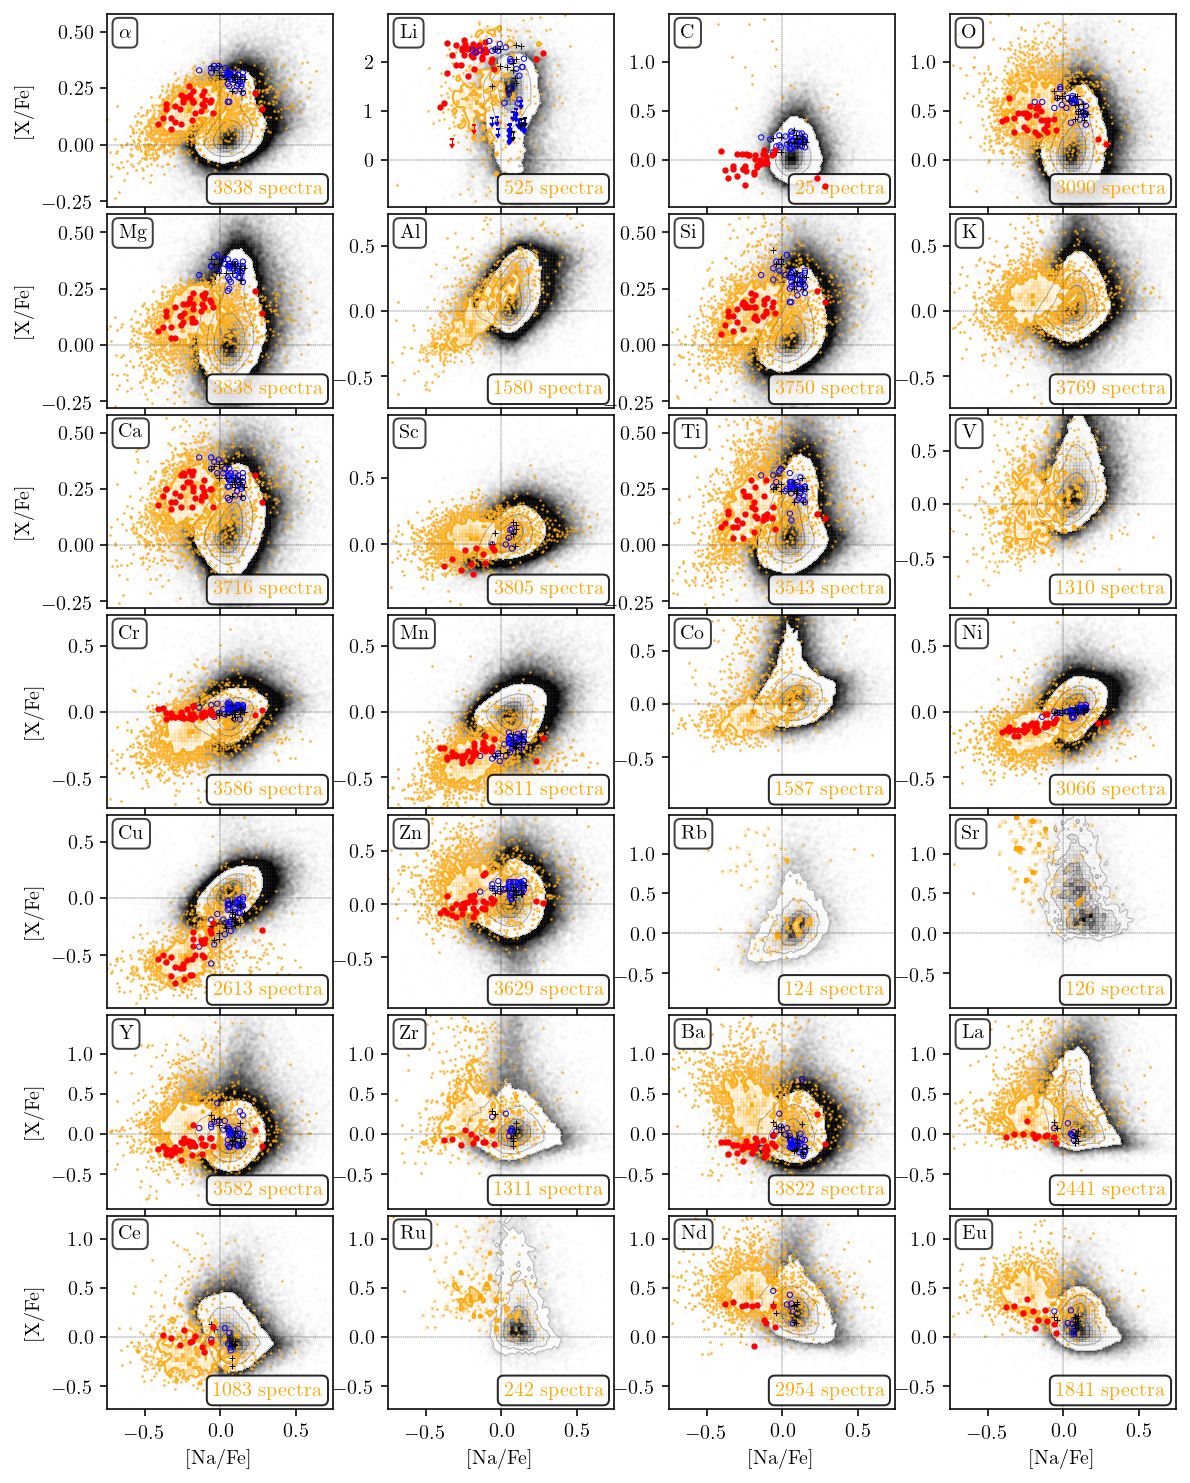

In [35]:
def plot_nafe_xfe_nissen(element_group_name, msto_only=False, good_plx=False):
    
    group_length = len(element_groups[element_group_name])
    
    if group_length <= 2:
        cols = group_length; rows = 1
        figsize = (4.05,2.5)
        dpi=250
    elif group_length == 3:
        cols = group_length; rows = 1
        figsize = (6.1,2.5)
        dpi=250
    elif group_length <= 5:
        cols = group_length; rows = 1
        figsize = (8.3,2.5)
        dpi=250
    elif group_length <= 8:
        cols = round(group_length/2); rows = 2
        figsize = (8.3,4.5)
        dpi=150
    else:
        print('I assume all 30 elements together')
        cols = 4; rows = 7
        figsize=(8.3,10.4)
        dpi=150
    
    if ('Li' in element_groups[element_group_name]) | (group_length > 8):
        f, gs = plt.subplots(rows,cols,figsize=figsize,sharex=True)
    else:
        f, gs = plt.subplots(rows,cols,figsize=figsize,sharex=True, sharey=True)

    for each_id, each in enumerate(element_groups[element_group_name]):

        if rows == 1:
            ax = gs[each_id]
        else:
            if each_id < cols:
                ax = gs[0,each_id]
            elif each_id < 2*cols:
                ax = gs[1,each_id-cols]
            elif each_id < 3*cols:
                ax = gs[2,each_id-2*cols]
            elif each_id < 4*cols:
                ax = gs[3,each_id-3*cols]
            elif each_id < 5*cols:
                ax = gs[4,each_id-4*cols]
            elif each_id < 6*cols:
                ax = gs[5,each_id-5*cols]
            elif each_id < 7*cols:
                ax = gs[6,each_id-6*cols]
        if each_id >= (rows-1)*cols:
            ax.set_xlabel('[Na/Fe]')
                
        add_nissen_nafe_xfe(ax, each)
        
        add_galah_nafe_xfe(ax, each, msto_only=msto_only, good_plx=good_plx)
        
        if each_id%cols==0:
            ax.set_ylabel('[X/Fe]')
            
#         if each in ['Sc','V','Cr','Mn','Co','Ni','Cu','Zn']:
#             ax.set_yticks([-0.5,0,0.5,1.0,1.5])

        if each == 'alpha':
            each = r'$\alpha$'
        ax.text(0.05,0.95,each,transform=ax.transAxes,ha='left',va='top',bbox=dict(boxstyle='round', facecolor='w', alpha=0.75))
        ax.axhline(lw=0.2,ls='dashed',color='k')
        ax.axvline(lw=0.2,ls='dashed',color='k')
        
    plt.tight_layout(h_pad=0,w_pad=0)

    if msto_only:
        plt.savefig('nafe_xfe_nissen_'+element_group_name+'_msto.png',dpi=dpi,bbox_inches='tight')
    elif good_plx:
        plt.savefig('nafe_xfe_nissen_'+element_group_name+'_plx.png',dpi=dpi,bbox_inches='tight')
    else:
        plt.savefig('nafe_xfe_nissen_'+element_group_name+'.png',dpi=dpi,bbox_inches='tight')
    #plt.close()

for each_element_group in element_groups.keys():
    plot_nafe_xfe_nissen(element_group_name=each_element_group)
    
# for each_element_group in element_groups.keys():
#     plot_nafe_xfe_nissen(element_group_name=each_element_group, msto_only = True)

# for each_element_group in element_groups.keys():
#     plot_nafe_xfe_nissen(element_group_name=each_element_group, good_plx = True)

In [ ]:
def test_plx correlation():

    for elem in ['Mg','Al','Si',
                 'Mn','Cu','Zn',
                 'Y' ,'Ba',]:
        f, (ax0,ax1,ax2) = plt.subplots(1,3,figsize=(15,5))
        plx = np.arange(0,20)
        n = []
        pc = []
        selection = (
            preliminary_low_alpha_halo & 
            (data['parallax_dr2']/data['parallax_error_dr2'] > 5) &
            (data['flag_'+elem+'_fe'] == 0)
        )
        #s0=ax0.scatter(data['fe_h'][selection],data[elem+'_fe'][selection],c=data['parallax_dr2'][selection]/data['parallax_error_dr2'][selection],vmin=5,vmax=20,s=1)
        s0=ax0.scatter(data['fe_h'][selection],data[elem+'_fe'][selection],c=100*(1000./data['parallax_dr2'][selection]-data['best_d'][selection])/data['best_d'][selection],vmin=-50,vmax=50,s=1)
        c=plt.colorbar(s0,ax=ax0)
        c.set_label('Distance difference Perc.')
        for plx_min in plx:
            selection = (
                preliminary_low_alpha_halo & 
                (data['parallax_dr2']/data['parallax_error_dr2'] > plx_min) &
                (data['flag_'+elem+'_fe'] == 0)
            )
            n.append(len(data['teff'][selection]))
            if len(data['teff'][selection]) > 3:
                pc.append(np.percentile(data[elem+'_fe'][selection],q=[16,50,84]))
            else:
                pc.append([np.nan,np.nan,np.nan])
        ax1.plot(plx,np.array(n))
        ax2.plot(plx,np.array(pc)[:,0],label='16th Perc.')
        ax2.plot(plx,np.array(pc)[:,1],label='50th Perc.')
        ax2.plot(plx,np.array(pc)[:,2],label='84th Perc.')
        ax0.set_xlabel('[Fe/H]')
        ax0.set_ylabel('['+elem+'/Fe]')
        ax1.set_xlabel('PLX SNR')
        ax2.set_xlabel('PLX SNR')
        ax1.set_ylabel('Spectra')
        ax2.set_ylabel('['+elem+'/Fe]')
        plt.tight_layout()
        plt.savefig('plx_dependence_'+elem+'.png',dpi=200,bbox_inches='tight')

In [18]:
def plot_xfe_hist(element_group_name, ax):
    
    colors = ['orange','purple','C0','C3','C6','C5']

    for each_i, each in enumerate(hist_element_groups[element_group_name]):
        
        each_k = each
        if each=='Fe':
            each_k = r'[Fe/H]'
        elif each=='alpha':
            each_k = r'[$\alpha$/Fe]'
        else:
            each_k = r'['+each+'/Fe]'
        
        if each =='Fe':
            lah_elem = (
                preliminary_low_alpha_halo & 
                (data['flag_Na_fe'] == 0) &
                (data['flag_fe_h'] == 0)
            )
        else:
            lah_elem = (
                preliminary_low_alpha_halo & 
                (data['flag_Na_fe'] == 0) &
                (data['flag_'+each+'_fe'] == 0)
            )

        if each in hist_element_groups['Fe']:
            bins = np.linspace(-2,-0.4,25)
        if each in hist_element_groups['O']:
            bins = np.linspace(-0.5,1.5,25)
        if each in hist_element_groups['alpha']:
            bins = np.linspace(-0.3,0.75,25)
        if each in hist_element_groups['odd_z']:
            bins = np.linspace(-1.0,1.0,25)
        if each in hist_element_groups['iron_peak_1']:
            bins = np.linspace(-1.0,1.0,25)
        if each in hist_element_groups['iron_peak_2']:
            bins = np.linspace(-1.0,1.0,25)
        if each in hist_element_groups['s_process']:
            bins = np.linspace(-1.0,2.0,25)
        if each in hist_element_groups['r_process']:
            bins = np.linspace(-0.6,1.1,25)
        if each in hist_element_groups['Li']:
            bins = np.linspace(-2,4.5,25)
        if each in hist_element_groups['rest']:
            bins = np.linspace(-0.75,2.5,25)

        if each == 'Fe':
            counts, bins = np.histogram(data['fe_h'][lah_elem], bins=bins)
            
            lah_sig2_low,lah_p50,lah_sig2_high = np.percentile(data['fe_h'][lah_elem],q=[2.275,50,100-2.275])
        else:
            counts, bins = np.histogram(data[each+'_fe'][lah_elem], bins=bins)
            lah_sig2_low,lah_p50,lah_sig2_high = np.percentile(data[each+'_fe'][lah_elem],q=[2.275,50,100-2.275])
        ax.hist(bins[:-1], bins, weights=counts, histtype='step', color=colors[each_i], density=True, lw=2./(0.2*each_i+1), label=each_k)

    #ax.legend(loc='upper right', fontsize=8)
    ax.legend(fontsize=8)

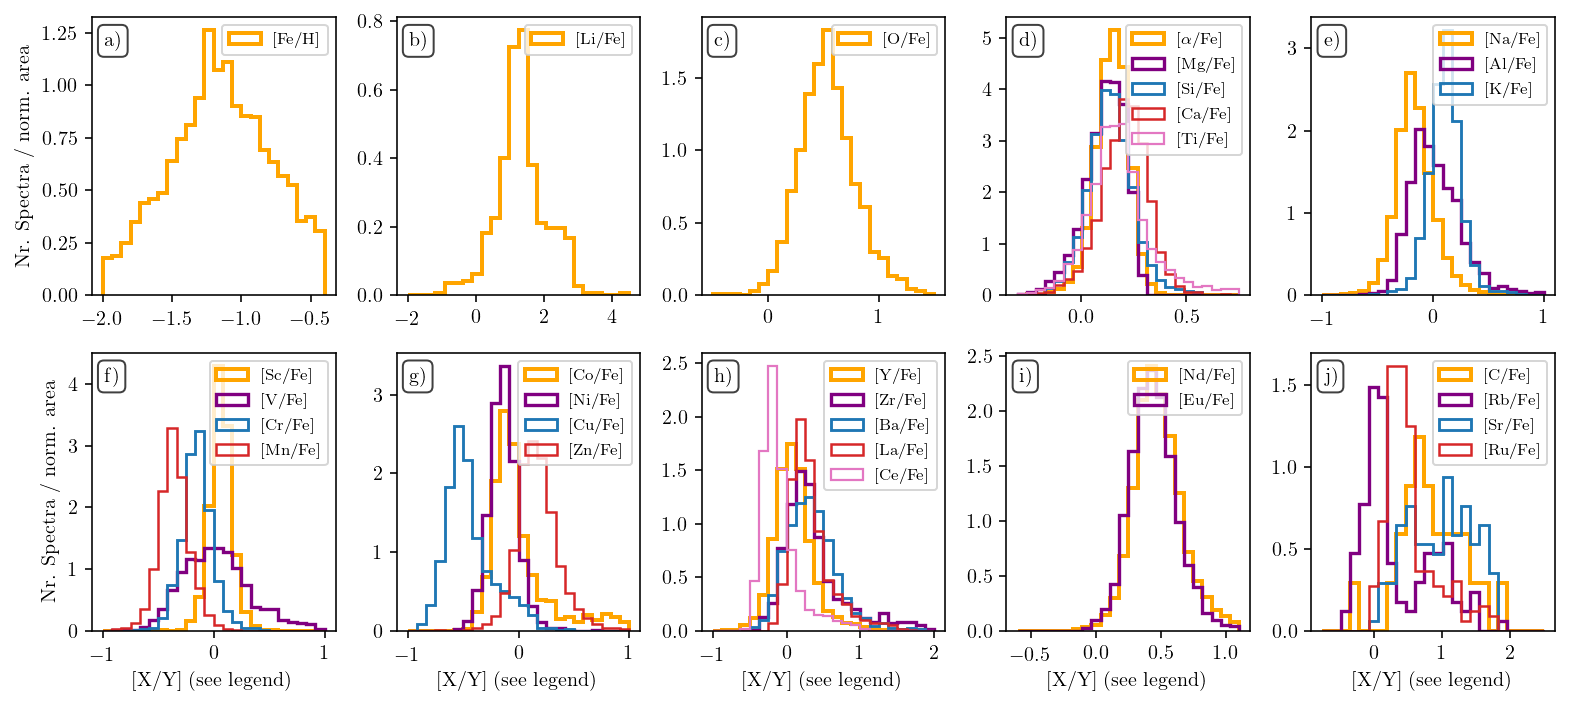

In [19]:
# We plot the [X/Y] histograms, but separate Li (larger span) and C, Rb, Sr, Ru (fewer measurements)

hist_element_groups = dict()
hist_element_groups['Fe'] = ['Fe']
hist_element_groups['Li'] = ['Li']
hist_element_groups['O'] = ['O']
hist_element_groups['alpha'] = ['alpha','Mg','Si','Ca','Ti']
hist_element_groups['odd_z'] = ['Na','Al','K']
hist_element_groups['iron_peak_1'] = ['Sc','V','Cr','Mn']
hist_element_groups['iron_peak_2'] = ['Co','Ni','Cu','Zn']
hist_element_groups['s_process'] = ['Y','Zr', 'Ba', 'La','Ce']
hist_element_groups['r_process'] = ['Nd','Eu']
hist_element_groups['rest'] = ['C','Rb','Sr','Ru']
# Plot Li and the less measured elements C, Rb, Sr, and Ru in a separate plot

f, gs = plt.subplots(2,5,figsize=(11,5))
for each_index, each_element_group in enumerate(
    ['Fe', 'Li', 'O', 'alpha', 'odd_z', 'iron_peak_1', 'iron_peak_2', 's_process', 'r_process', 'rest']
    ):
    if each_index <5:
        ax=gs[0,each_index]
    else:
        ax=gs[1,each_index-5]
        
    if each_index%5==0:
        ax.set_ylabel('Nr. Spectra / norm. area')
    if each_index >= 5:
        ax.set_xlabel('[X/Y] (see legend)')
    ax.text(0.05,0.95,panels[each_index],transform=ax.transAxes,ha='left',va='top',bbox=dict(boxstyle='round', facecolor='w', alpha=0.75))

    plot_xfe_hist(element_group_name=each_element_group, ax=ax)
    
plt.tight_layout()
plt.savefig('xfe_hist.png',dpi=300,bbox_inches='tight')

# f, gs = plt.subplots(1,2,figsize=(5.7,2.6))

# # Plot Li and the less measured elements C, Rb, Sr, and Ru in a separate plot
# for each_index, each_element_group in enumerate(['Li','rest']):

#     ax = gs[each_index]
#     if each_index==0:
#         ax.set_ylabel('Nr. Spectra / norm. area')
#     ax.set_xlabel('[X/Y] (see legend)')
#     ax.text(0.05,0.95,panels[each_index],transform=ax.transAxes,ha='left',va='top',bbox=dict(boxstyle='round', facecolor='w', alpha=0.75))

#     plot_xfe_hist(element_group_name=each_element_group, ax=ax)

# plt.tight_layout()
# plt.savefig('xfe_hist_lirest.png',dpi=300,bbox_inches='tight')


In [20]:
galah_elements = ['Fe','alpha','Li','C','O',
                  'Na','Mg','Al','Si','K',
                  'Ca','Sc','Ti','V' ,'Cr',
                  'Mn','Co','Ni','Cu','Zn',
                  'Rb','Sr','Y' ,'Zr','Ba',
                  'La','Ce','Ru','Nd','Eu']

diff_ps = 1.0

for ix, ex in enumerate(galah_elements):
    for iy, ey in enumerate(galah_elements):
        if iy > ix:
            if ex == 'Fe':
                flagx = 'flag_fe_h'
                valuex = 'fe_h'
                errx = 'e_fe_h'
            else:
                flagx = 'flag_'+ex+'_fe'
                valuex = ex+'_fe'
                errx = 'e_'+ex+'_fe'
            if ey == 'Fe':
                flagy = 'flag_fe_h'
                valuey = 'fe_h'
                errx = 'e_fe_h'
            else:
                flagy = 'flag_'+ey+'_fe'
                valuey = ey+'_fe'
                erry = 'e_'+ey+'_fe'

            selection = (
                basic_cuts & 
                preliminary_low_alpha_halo &
                (data[flagx]==0) &
                (data[flagy]==0) &
                (data[errx] <= 0.15) &
                (data[erry] <= 0.15)
            )
            if len(data[valuex][selection]) > 100:
                pearsonnumber = scipy.stats.pearsonr(
                    x = data[valuex][selection],
                    y = data[valuey][selection],
                )
                spearmannumber = scipy.stats.spearmanr(
                    data[valuex][selection],
                    data[valuey][selection],
                )
            if np.abs(pearsonnumber[0]) > 0.6:
                print(ex,ey,"{:.2f}".format(pearsonnumber[0]))
            if (
                ((ex == 'alpha') & (ey in ['Mg','Si'])) |
                ((ex == 'Mg') & (ey in ['alpha','Si'])) |
                ((ex == 'Na') & (ey in ['Al','Cu']))|
                ((ex == 'Mn') & (ey in ['Ni','Cu']))|
                ((ex == 'Ni') & (ey in ['Mn','Cu']))
            ):
                if ex=='alpha':
                    ext = r'$\alpha$'
                else:
                    ext = ex
                    
                if diff_ps > np.abs(pearsonnumber[0]-spearmannumber[0]):
                    diff_ps = np.abs(pearsonnumber[0]-spearmannumber[0])

                pr = ext+'-'+ey+' ('+"{:.2f}".format(pearsonnumber[0])+')'
                print(pr)
                np.savetxt('../depending_text/pearsonr_'+ex+'_'+ey+'.tex',[pr+'%'],fmt='%s',newline='')
np.savetxt('../depending_text/pearsonr_spearmanr.tex',["{:.3f}".format(diff_ps)+'%'],fmt='%s',newline='')
print('Difference Pearson+Spearman: ',"{:.3f}".format(diff_ps))

alpha Mg 0.63
$\alpha$-Mg (0.63)
alpha Si 0.63
$\alpha$-Si (0.63)
Na Al 0.71
Na-Al (0.71)
Na-Cu (0.58)
Mg-Si (0.36)
Mn-Ni (0.40)
Mn-Cu (0.56)
Ni Cu 0.64
Ni-Cu (0.64)
Ni Ru -0.62
Zn Ru 0.61
Y Ba 0.66
Zr La 0.66
Zr Ce 0.64
Zr Ru 0.68
La Ce 0.87
La Nd 0.80
La Eu 0.60
Ce Ru 0.60
Ce Nd 0.73
Ru Nd 0.60
Nd Eu 0.63
Difference Pearson+Spearman:  0.003


$\mathrm{[Mg/\alpha]} = 0.02_{-0.05}^{+0.09}$
$\mathrm{[Mg/Si]} = 0.02_{-0.10}^{+0.13}$,
$\mathrm{[Na/Al]} = 0.13_{-0.12}^{+0.16}$
$\mathrm{[Mn/Ni]} = 0.21_{-0.13}^{+0.14}$
$\mathrm{[Mn/Cu]} = -0.11_{-0.15}^{+0.19}$
Outliers upright [Cu/Mn]: 430 spectra (16\%)


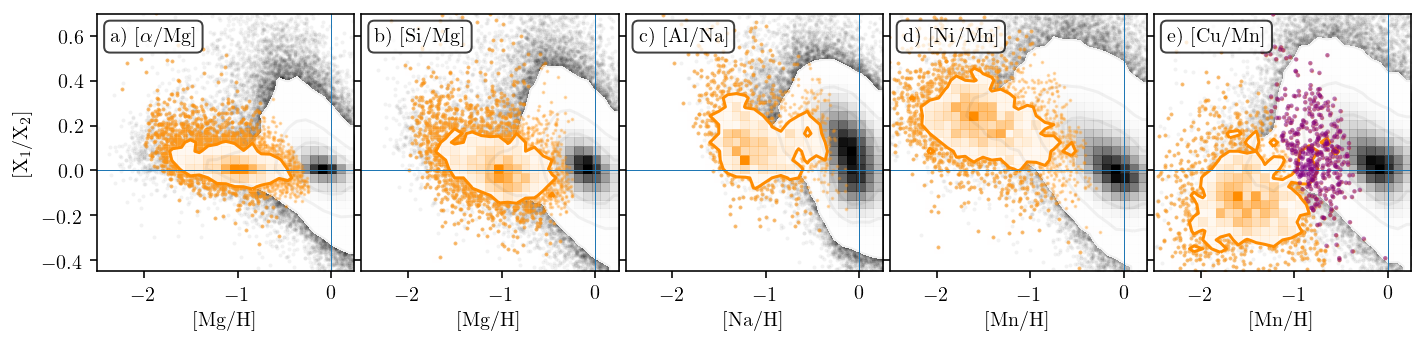

In [21]:
def plot_group_information_content_corner():
    
    f, gs = plt.subplots(1,5,figsize=(10,2.5),sharey=True)

    pairs = np.array([
        ['Mg','alpha'],
        ['Mg','Si'],
        ['Na','Al'],
        ['Mn','Ni'],
        ['Mn','Cu']
    ])
    
    for ind, (x,y) in enumerate(pairs):

        ax = gs[ind]
        xy_flag = basic_cuts & (data['flag_fe_h'] == 0) & (data['flag_'+x+'_fe']==0) & (data['flag_'+y+'_fe'] == 0)

        if x == 'Mg': bins = (np.linspace(-2.5,0.25, 30),np.linspace(-0.45,0.7,30))
        if x == 'Na': bins = (np.linspace(-2.5,0.25, 30),np.linspace(-0.45,0.7,30))
        if x == 'Mn': bins = (np.linspace(-2.5,0.25, 30),np.linspace(-0.45,0.7,30))  

#         ax.hist2d(
#             data[x+'_fe'][xy_flag] + data['fe_h'][xy_flag],
#             data[y+'_fe'][xy_flag] - data[x+'_fe'][xy_flag],
#             bins=bins,cmap='Greys',cmin=1,norm=LogNorm(),zorder=1
#         )
        corner.hist2d(
            data[x+'_fe'][xy_flag] + data['fe_h'][xy_flag],
            data[y+'_fe'][xy_flag] - data[x+'_fe'][xy_flag],
            color='k',
            plot_datapoints=True,
            levels = (0.68,0.90,0.98),
            ax=ax,
            data_kwargs = dict(alpha=0.05),
            contour_kwargs = dict(alpha=0.05),
            contourf_kwargs = dict(alpha=0.05),
            bins=bins,
            zorder=0
        )
        ax.scatter(
            data[x+'_fe'][xy_flag & preliminary_low_alpha_halo] + data['fe_h'][xy_flag & preliminary_low_alpha_halo],
            data[y+'_fe'][xy_flag & preliminary_low_alpha_halo] - data[x+'_fe'][xy_flag & preliminary_low_alpha_halo],
            color='DarkOrange',
            zorder=1,s=0.75,alpha=0.3
        )
        corner.hist2d(
            data[x+'_fe'][xy_flag & preliminary_low_alpha_halo] + data['fe_h'][xy_flag & preliminary_low_alpha_halo],
            data[y+'_fe'][xy_flag & preliminary_low_alpha_halo] - data[x+'_fe'][xy_flag & preliminary_low_alpha_halo],
            color='DarkOrange',
            plot_datapoints=True,
            levels=(0.68,),
            ax=ax,
            data_kwargs = dict(alpha=0.3),
            bins=bins,
            zorder=3
        )
        ax.set_xlabel('['+x+'/H]')

        p16,p50,p84 = np.percentile(data[y+'_fe'][xy_flag & preliminary_low_alpha_halo] - data[x+'_fe'][xy_flag & preliminary_low_alpha_halo], q=[16,50,84])

        if ind == 0:
            ax.set_ylabel(r'[$\mathrm{X_1}/\mathrm{X_2}$]')
        if y=='alpha':
            ratio_stats = r'$\mathrm{['+x+'/\\alpha]} = '+"{:.2f}".format(p50)+'_{-'+"{:.2f}".format(p50-p16)+'}^{+'+"{:.2f}".format(p84-p50)+'}$'
            ax.text(0.05,0.95,panels[ind]+r' [$\alpha$/'+x+']' ,transform=ax.transAxes,ha='left',va='top',bbox=dict(boxstyle='round', facecolor='w', alpha=0.75))
        else:
            ax.text(0.05,0.95,panels[ind]+' ['+y+'/'+x+']',transform=ax.transAxes,ha='left',va='top',bbox=dict(boxstyle='round', facecolor='w', alpha=0.75))
            ratio_stats = r'$\mathrm{['+x+'/'+y+']} = '+"{:.2f}".format(p50)+'_{-'+"{:.2f}".format(p50-p16)+'}^{+'+"{:.2f}".format(p84-p50)+'}$'
            if y=='Si':
                ratio_stats=ratio_stats+','
        ax.axhline(0,c='C0',lw=0.5)
        ax.axvline(0,c='C0',lw=0.5)
        ax.set_xticks([-2,-1,0])
        
        
        print(ratio_stats)
        if (x=='Mn') & (y=='Cu'):
            upright = (
                xy_flag & 
                preliminary_low_alpha_halo & 
                (data['Cu_fe']-data['Mn_fe'] + (data['Mn_fe']+data['fe_h']) > -1)
            )
            outliers = str(len(data['Mn_fe'][upright]))+' spectra ('+str(int(np.round(
                           100*len(data['Mn_fe'][upright])/
                           len(data[y+'_fe'][xy_flag & preliminary_low_alpha_halo]))))+'\%)'
            
            print('Outliers upright [Cu/Mn]: '+outliers)
            
            np.savetxt('../depending_text/mn_h_cu_mn_upright.tex',
                       [outliers],
                       fmt='%s')
            ax.scatter(
                data[x+'_fe'][upright] + data['fe_h'][upright],
                data[y+'_fe'][upright] - data[x+'_fe'][upright],
                c='purple',s=5,edgecolors='None',alpha=0.5,
                zorder=3
            )
            
        ax.set_xlim(bins[0][0],bins[0][-1])
        ax.set_ylim(bins[1][0],bins[1][-1])
            
        np.savetxt('../depending_text/trace_stats_'+x+'_'+y+'.tex',[ratio_stats],fmt='%s')
        
    plt.tight_layout(w_pad=0)
    plt.savefig('groupinformation_xh_corner.png',dpi=300,bbox_inches='tight')

plot_group_information_content_corner()

In [26]:
# Table of significance of sepearations of lah and hah
# based on the percentiles and sigma-clipped mean+stds of the individual [X/Y] distributions

def robustly_calculate_lah_hah_separation(sigma = 2):
    """
    Perform (by default with 2-sigma) a sigma clipping and then calculate means and standard deviations.
    Other options are either 3-sigma clipping or no sigma clipping at all.
    """
    element_groups = dict()
    element_groups['iron'] = ['Fe']
    element_groups['light_proton'] = ['Li','C','O']
    element_groups['alpha'] = ['alpha','Mg','Si','Ca','Ti']
    element_groups['odd_z'] = ['Na','Al','K']
    element_groups['iron_peak'] = ['Sc','V','Cr','Mn','Co','Ni','Cu','Zn']
    element_groups['s_process'] = ['Rb','Sr', 'Y', 'Zr', 'Ba', 'La', 'Ce']
    element_groups['r_process'] = ['Ru','Nd','Eu']

    lah_dictionary = dict()
    
    table = [
        ['\\begingroup'],
        ['\\renewcommand{\\arraystretch}{1.19}'],
        ['\\begin{table*}'],
        ['\\centering'],
        ['\\caption{\\textbf{Numbers of measurements and statistic properties of element abundances [X/Y] of the preliminary selected low-$\\alpha$ ($l$) and high-$\\alpha$ ($h$) halo stars.} For each abundance ratio, we report 16/50/$84^\text{th}$ percentiles. We further calculate mean $\\mu_i$, standard deviation $\\sigma_i$, and skewness $\\tilde{\\mu}_{i,3}$ after performing 2-$\\sigma$-clipping (removing the top/bottom $2.275\\%$ of the sample). In addition to the difference of the means we report their significance $r$. Major element groups are separated by horizontal lines: firstly [Fe/H] followed by light, $\\alpha$-process elements, light odd Z, iron-peak, and neutron-capture elements.}'],
        ['\\label{tab:xfe_percentiles}'],
        ['\\begin{tabular}{c|cccc|cccc|cc}'],
        ['\\hline \\hline'],
        ['\\multirow{2}{*}{$\\mathrm{[X/Y]}$} & \\multicolumn{4}{c}{Prel. low-$\\alpha$ halo (Eq.~\\protect\\ref{eq:prelim_low_alpha_halo})} & \\multicolumn{4}{c}{Prel. high-$\\alpha$ halo (Eq.~\\protect\\ref{eq:prelim_high_alpha_halo})} & \\multirow{2}{*}{$\\mu_l - \\mu_h$} & \\multirow{2}{*}{$r = \\frac{\\vert \\mu_l - \\mu_h \\vert}{\\sqrt{\\sigma_l^2 + \\sigma_h^2}}$}\\\\'],
        [' & Nr. & Perc. 16/50/84 & $\\mu_l \pm \\sigma_l$ & $\\tilde{\\mu}_{l,3}$ & Nr. & Perc. 16/50/84 & $\\mu_h \\pm \\sigma_h$ & $\\tilde{\\mu}_{h,3}$ & &  \\\\'],
        ['\\hline']
    ]

    for each_group in element_groups.keys():
        alpha_scatter2 = ''
        for each_elem in element_groups[each_group]:
            name = '$\\mathrm{['+each_elem+'/Fe]}$'
            if each_elem == 'Fe':
                name = '$\\mathrm{[Fe/H]}$'
            if each_elem == 'alpha':
                name = '$\\mathrm{[\\alpha/Fe]}$'

            if each_elem =='Fe':
                lah_elem = (
                    preliminary_low_alpha_halo & 
                    (data['flag_Na_fe'] == 0) &
                    (data['flag_fe_h'] == 0)
                )
                hah_elem = (
                    preliminary_high_alpha_halo & 
                    (data['flag_Na_fe'] == 0) &
                    (data['flag_fe_h'] == 0)
                )

                nr_lah = len(data['fe_h'][lah_elem])
                nr_hah = len(data['fe_h'][hah_elem])

                lah_sig3_low,lah_sig2_low,lah_p16,lah_p50,lah_p84,lah_sig2_high,lah_sig3_high = np.percentile(data['fe_h'][lah_elem],q=[0.27,2.275,16,50,84,100-2.275,100-0.27])
                sig2 = lah_elem & (lah_sig2_low < data['fe_h']) & (data['fe_h'] < lah_sig2_high)
                sig3 = lah_elem & (lah_sig3_low < data['fe_h']) & (data['fe_h'] < lah_sig3_high)           
                if sigma==3:
                    lah_mean,lah_std, lah_skew = (np.mean(data['fe_h'][sig3]),np.std(data['fe_h'][sig3]),scipy.stats.skew(data['fe_h'][sig3]))
                elif sigma==2:
                    lah_mean,lah_std, lah_skew = (np.mean(data['fe_h'][sig2]),np.std(data['fe_h'][sig2]),scipy.stats.skew(data['fe_h'][sig2]))
                else:
                    lah_mean,lah_std, lah_skew = (np.mean(data['fe_h'][lah_elem]),np.std(data['fe_h'][lah_elem]),scipy.stats.skew(data['fe_h'][lah_elem]))
                                
                hah_sig3_low,hah_sig2_low,hah_p16,hah_p50,hah_p84,hah_sig2_high,hah_sig3_high = np.percentile(data['fe_h'][hah_elem],q=[0.27,2.275,16,50,84,100-2.275,100-0.27])
                sig2 = hah_elem & (hah_sig2_low < data['fe_h']) & (data['fe_h'] < hah_sig2_high)
                sig3 = hah_elem & (hah_sig3_low < data['fe_h']) & (data['fe_h'] < hah_sig3_high)           
                if sigma==3:
                    hah_mean,hah_std, hah_skew = (np.mean(data['fe_h'][sig3]),np.std(data['fe_h'][sig3]),scipy.stats.skew(data['fe_h'][sig3]))
                elif sigma==2:
                    hah_mean,hah_std, hah_skew = (np.mean(data['fe_h'][sig2]),np.std(data['fe_h'][sig2]),scipy.stats.skew(data['fe_h'][sig2]))
                else:
                    hah_mean,hah_std, hah_skew = (np.mean(data['fe_h'][hah_elem]),np.std(data['fe_h'][hah_elem]),scipy.stats.skew(data['fe_h'][hah_elem]))

            else:
                lah_elem = (
                    preliminary_low_alpha_halo & 
                    (data['flag_Na_fe'] == 0) &
                    (data['flag_'+each_elem+'_fe'] == 0)
                )
                hah_elem = (
                    preliminary_high_alpha_halo & 
                    (data['flag_Na_fe'] == 0) &
                    (data['flag_'+each_elem+'_fe'] == 0)
                )

                nr_lah = len(data[each_elem+'_fe'][lah_elem])
                nr_hah = len(data[each_elem+'_fe'][hah_elem])

                if each_elem == 'alpha':
                    
                    nr_lah_nafe_0 = len(data[each_elem+'_fe'][lah_elem & (data['Na_fe'] > 0)])
                    
                    nafe_0 = str(nr_lah_nafe_0)+' spectra, that is, '+str(int(np.round(100*nr_lah_nafe_0/nr_lah)))+'\\%)'
                    np.savetxt('../depending_text/low_alpha_halo_nafe_0.tex',[nafe_0+'%'],fmt='%s',newline='')
                
                lah_sig3_low,lah_sig2_low,lah_p16,lah_p50,lah_p84,lah_sig2_high,lah_sig3_high = np.percentile(data[each_elem+'_fe'][lah_elem],q=[0.27,2.275,16,50,84,100-2.275,100-0.27])
                sig2 = lah_elem & (lah_sig2_low < data[each_elem+'_fe']) & (data[each_elem+'_fe'] < lah_sig2_high)
                sig3 = lah_elem & (lah_sig3_low < data[each_elem+'_fe']) & (data[each_elem+'_fe'] < lah_sig3_high)           
                if sigma==3:
                    lah_mean,lah_std, lah_skew = (np.mean(data[each_elem+'_fe'][sig3]),np.std(data[each_elem+'_fe'][sig3]),scipy.stats.skew(data[each_elem+'_fe'][sig3]))
                elif sigma==2:
                    lah_mean,lah_std, lah_skew = (np.mean(data[each_elem+'_fe'][sig2]),np.std(data[each_elem+'_fe'][sig2]),scipy.stats.skew(data[each_elem+'_fe'][sig2]))
                else:
                    lah_mean,lah_std, lah_skew = (np.mean(data[each_elem+'_fe'][lah_elem]),np.std(data[each_elem+'_fe'][lah_elem]),scipy.stats.skew(data[each_elem+'_fe'][lah_elem]))

                if each_elem in ['Li','O','Ni','Zn','V']:
                    np.savetxt('../depending_text/lah_p16_p84_'+each_elem+'.tex',["{:.2f}".format(lah_p16)+r'$  and $'+"{:.2f}".format(lah_p84)+'%'],fmt='%s',newline='')
                if each_elem in ['O']:
                    alpha_scatter = ' for [$\\alpha$/Fe], [Mg/Fe], [Si/Fe], [Ca/Fe], and [Ti/Fe], compared to the much higher value of '+"{:.2f}".format(lah_std)+' for [O/Fe]'
                if each_elem in ['O','alpha','Mg','Ti','Al','V','Co','Cu','Rb','Y','Zr','Ba','La','Ru','Ce','Nd','Eu']:
                    np.savetxt('../depending_text/skewness_'+each_elem+'_lah.tex',["{:.2f}".format(lah_skew)+'%'],fmt='%s',newline='')
                if each_elem in ['Ti','Al','K','Cu','V','Co','Ni','Zr','La','Ce']:
                    np.savetxt('../depending_text/lah_'+each_elem+'_detection_percentage.tex',
                        [str(int(np.round(100*len(data[each_elem+'_fe'][lah_elem])/len(data[each_elem+'_fe'][preliminary_low_alpha_halo & (data['flag_Na_fe'] == 0)]))))+'\\%%'],
                               fmt='%s',newline=''
                              )
                if each_elem in ['alpha','Mg','Si','Ca','Ti']:
                    if each_elem == 'Ti':
                        alpha_scatter = alpha_scatter2+'and '+"{:.2f}".format(lah_std)+alpha_scatter
                        np.savetxt('../depending_text/alpha_scatter.tex',[alpha_scatter+'%'],fmt='%s',newline='')
                    else:
                        alpha_scatter2 = alpha_scatter2+"{:.2f}".format(lah_std)+', '
                    
                hah_sig3_low,hah_sig2_low,hah_p16,hah_p50,hah_p84,hah_sig2_high,hah_sig3_high = np.percentile(data[each_elem+'_fe'][hah_elem],q=[0.27,2.275,16,50,84,100-2.275,100-0.27])
                sig2 = hah_elem & (hah_sig2_low < data[each_elem+'_fe']) & (data[each_elem+'_fe'] < hah_sig2_high)
                sig3 = hah_elem & (hah_sig3_low < data[each_elem+'_fe']) & (data[each_elem+'_fe'] < hah_sig3_high)           
                if sigma==3:
                    hah_mean,hah_std, hah_skew = (np.mean(data[each_elem+'_fe'][sig3]),np.std(data[each_elem+'_fe'][sig3]),scipy.stats.skew(data[each_elem+'_fe'][sig3]))
                elif sigma==2:
                    hah_mean,hah_std, hah_skew = (np.mean(data[each_elem+'_fe'][sig2]),np.std(data[each_elem+'_fe'][sig2]),scipy.stats.skew(data[each_elem+'_fe'][sig2]))
                else:
                    hah_mean,hah_std, hah_skew = (np.mean(data[each_elem+'_fe'][hah_elem]),np.std(data[each_elem+'_fe'][hah_elem]),scipy.stats.skew(data[each_elem+'_fe'][hah_elem]))

            separation1 = lah_mean - hah_mean
            if each_elem in ['Cu','Y','Nd','Eu']:
                    np.savetxt('../depending_text/lah_mul_muh_diff_'+each_elem+'.tex',["{:.2f}".format(np.abs(separation1))+'%'],fmt='%s',newline='')

            separation2 = np.abs(lah_mean - hah_mean) / np.sqrt((lah_std)**2 + (hah_std)**2)

            if each_elem in ['Cr','Mn','Ni','Zn','Y','Ba','Ce','Nd','Eu']:
                np.savetxt('../depending_text/lah_mul_sigmal_'+each_elem+'.tex',["{:.2f}".format(lah_mean)+' \\pm '+"{:.2f}".format(lah_std)+'%'],fmt='%s',newline='')
            
            table.append([name+' & '+
                          # Low-alpha halo
                          str(nr_lah)+' & '+
                          '$'+"{:.2f}".format(lah_p50)+'_{-'+"{:.2f}".format(lah_p50-lah_p16)+'}^{+'+"{:.2f}".format(lah_p84-lah_p50)+'}$ & '+
                          '$'+"{:.2f}".format(lah_mean)+' \\pm '+"{:.2f}".format(lah_std)+'$ & '+
                          '$'+"{:.2f}".format(lah_skew)+'$ & '+                          
                          # High-alpha halo
                          str(nr_hah)+' & '+
                          '$'+"{:.2f}".format(hah_p50)+'_{-'+"{:.2f}".format(hah_p50-hah_p16)+'}^{+'+"{:.2f}".format(hah_p84-hah_p50)+'}$ & '+
                          '$'+"{:.2f}".format(hah_mean)+' \\pm '+"{:.2f}".format(hah_std)+'$ & '+
                          '$'+"{:.2f}".format(hah_skew)+'$ & '+
                          # Separations
                          '$'+"{:.2f}".format(separation1)+'$ & '+                      
                          '$'+"{:.2f}".format(separation2)+'$ '+                      
                          ' \\\\'])

            lah_dictionary['mu_'+each_elem] = lah_mean
            lah_dictionary['sigma_'+each_elem] = lah_std
            
        table.append(['\\hline'])

    table.append(['\\end{tabular}'])
    table.append(['\\end{table*}'])
    table.append(['\\endgroup'])
    table=np.array(table)
    
    if sigma==2:
        np.savetxt('../tables/xfe_percentiles.tex',table,fmt='%s')
    elif sigma==3:
        np.savetxt('../tables/xfe_percentiles_3sig.tex',table,fmt='%s')
    else:
        np.savetxt('../tables/xfe_percentiles_nosig.tex',table,fmt='%s')

    return lah_dictionary
        
lah_distributions = robustly_calculate_lah_hah_separation(sigma=2)
#lah_distributions = robustly_calculate_lah_hah_separation(sigma=3)
#lah_distributions =  robustly_calculate_lah_hah_separation(sigma=0)

In [23]:
# Save the mu and sigma for the low-alpha halo in ../data/low_alpha_halo_distributions.csv and .pickle
galah_elements = ['Fe','alpha','Li','C','O',
                  'Na','Mg','Al','Si','K',
                  'Ca','Sc','Ti','V' ,'Cr',
                  'Mn','Co','Ni','Cu','Zn',
                  'Rb','Sr','Y' ,'Zr','Ba',
                  'La','Ce','Ru','Nd','Eu']
w = csv.writer(open('../data/low_alpha_halo_distributions.csv', 'w'))
w.writerow(['#element', 'mu', 'sigma'])
for element in galah_elements:
    w.writerow([element, lah_distributions['mu_'+element], lah_distributions['sigma_'+element]])
f = open("../data/low_alpha_halo_distributions.pickle","wb")
pickle.dump(lah_distributions,f)
f.close()

In [24]:
# def plot_group_information_content_corner():
    
#     f, gs = plt.subplots(1,5,figsize=(10,2.5),sharey=True)

#     pairs = np.array([
#         ['Mg','alpha'],
#         ['Mg','Si'],
#         ['Na','Al'],
#         ['Mn','Ni'],
#         ['Mn','Cu']
#     ])
    
#     for ind, (x,y) in enumerate(pairs):

#         ax = gs[ind]
#         xy_flag = basic_cuts & (data['flag_fe_h'] == 0) & (data['flag_'+x+'_fe']==0) & (data['flag_'+y+'_fe'] == 0)

#         if x == 'Mg': bins = (np.linspace(-2.5,0.25, 30),np.linspace(-0.45,0.7,30))
#         if x == 'Na': bins = (np.linspace(-2.5,0.25, 30),np.linspace(-0.45,0.7,30))
#         if x == 'Mn': bins = (np.linspace(-2.5,0.25, 30),np.linspace(-0.45,0.7,30))  

# #         ax.hist2d(
# #             data[x+'_fe'][xy_flag] + data['fe_h'][xy_flag],
# #             data[y+'_fe'][xy_flag] - data[x+'_fe'][xy_flag],
# #             bins=bins,cmap='Greys',cmin=1,norm=LogNorm(),zorder=1
# #         )
#         corner.hist2d(
#             data[x+'_fe'][xy_flag] + data['fe_h'][xy_flag],
#             data[y+'_fe'][xy_flag] - data[x+'_fe'][xy_flag],
#             color='k',
#             plot_datapoints=True,
#             levels = (0.68,0.90,0.98),
#             ax=ax,
#             data_kwargs = dict(alpha=0.05),
#             contour_kwargs = dict(alpha=0.05),
#             contourf_kwargs = dict(alpha=0.05),
#             bins=bins,
#             zorder=0
#         )
#         ax.scatter(
#             data[x+'_fe'][xy_flag & preliminary_low_alpha_halo] + data['fe_h'][xy_flag & preliminary_low_alpha_halo],
#             data[y+'_fe'][xy_flag & preliminary_low_alpha_halo] - data[x+'_fe'][xy_flag & preliminary_low_alpha_halo],
#             color='DarkOrange',
#             zorder=1,s=0.75,alpha=0.3
#         )
#         corner.hist2d(
#             data[x+'_fe'][xy_flag & preliminary_low_alpha_halo] + data['fe_h'][xy_flag & preliminary_low_alpha_halo],
#             data[y+'_fe'][xy_flag & preliminary_low_alpha_halo] - data[x+'_fe'][xy_flag & preliminary_low_alpha_halo],
#             color='DarkOrange',
#             plot_datapoints=True,
#             levels=(0.68,),
#             ax=ax,
#             data_kwargs = dict(alpha=0.3),
#             bins=bins,
#             zorder=3
#         )
#         ax.set_xlabel('['+x+'/H]')

#         p16,p50,p84 = np.percentile(data[y+'_fe'][xy_flag & preliminary_low_alpha_halo] - data[x+'_fe'][xy_flag & preliminary_low_alpha_halo], q=[16,50,84])

#         if ind == 0:
#             ax.set_ylabel(r'[$\mathrm{X_1}/\mathrm{X_2}$]')
#         if y=='alpha':
#             ratio_stats = r'$\mathrm{['+x+'/\\alpha]} = '+"{:.2f}".format(p50)+'_{-'+"{:.2f}".format(p50-p16)+'}^{+'+"{:.2f}".format(p84-p50)+'}$'
#             ax.text(0.05,0.95,panels[ind]+r' [$\alpha$/'+x+']' ,transform=ax.transAxes,ha='left',va='top',bbox=dict(boxstyle='round', facecolor='w', alpha=0.75))
#         else:
#             ax.text(0.05,0.95,panels[ind]+' ['+y+'/'+x+']',transform=ax.transAxes,ha='left',va='top',bbox=dict(boxstyle='round', facecolor='w', alpha=0.75))
#             ratio_stats = r'$\mathrm{['+x+'/'+y+']} = '+"{:.2f}".format(p50)+'_{-'+"{:.2f}".format(p50-p16)+'}^{+'+"{:.2f}".format(p84-p50)+'}$'
#             if y=='Si':
#                 ratio_stats=ratio_stats+','
#         ax.axhline(0,c='C0',lw=0.5)
#         ax.axvline(0,c='C0',lw=0.5)
#         ax.set_xticks([-2,-1,0])
        
        
#         print(ratio_stats)
#         if (x=='Mn') & (y=='Cu'):
#             upright = (
#                 xy_flag & 
#                 preliminary_low_alpha_halo & 
#                 (data['Cu_fe']-data['Mn_fe'] + (data['Mn_fe']+data['fe_h']) > -1)
#             )
#             outliers = str(len(data['Mn_fe'][upright]))+' spectra ('+str(int(np.round(
#                            100*len(data['Mn_fe'][upright])/
#                            len(data[y+'_fe'][xy_flag & preliminary_low_alpha_halo]))))+'\%)'
            
#             print('Outliers upright [Cu/Mn]: '+outliers)
            
#             np.savetxt('../depending_text/mn_h_cu_mn_upright.tex',
#                        [outliers],
#                        fmt='%s')
#             ax.scatter(
#                 data[x+'_fe'][upright] + data['fe_h'][upright],
#                 data[y+'_fe'][upright] - data[x+'_fe'][upright],
#                 c='purple',s=5,edgecolors='None',alpha=0.5,
#                 zorder=3
#             )
            
#         ax.set_xlim(bins[0][0],bins[0][-1])
#         ax.set_ylim(bins[1][0],bins[1][-1])
            
#         np.savetxt('../depending_text/trace_stats_'+x+'_'+y+'.tex',[ratio_stats],fmt='%s')
        
#     plt.tight_layout(w_pad=0)
#     plt.savefig('groupinformation_xh_corner.png',dpi=300,bbox_inches='tight')

# plot_group_information_content_corner()